# CELLECT Analyzer tool 

Tool to analyse SCZ CELLECT output prioritization files.

### Import all needed modules

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path # to search for the .cvs files
from sklearn.metrics import r2_score
from matplotlib_venn import venn2
from collections import Counter
%matplotlib inline
from matplotlib_venn import venn3
from adjustText import adjust_text

### Function definitions

In [2]:
# This searches the actual CELLECT output folder
# but that is currently full of test files
# directory = '/home/eerdem/CELLECT/out/'
# file_dict = {}
# for path in Path(directory).rglob('prioritization.csv'):
#     full_path = str(path)
#     (name, method,__, __) = path.parts[-4:]
#     name = name[8:] # CELLECT- is 8 long
#     method = method[8:]
#     print(name, method)
#     if name not in file_dict:
#         file_dict[name] = {}
#     file_dict[name].update({method:full_path})

def csv_file(directory):
    '''Searches for all prioritization.csv in the directory. 
    This assumes that the .csv files are in a 'CELLECT-' folder for correct parsing,
    and that these folders are in another folder which is how the data will be referenced to.'''
    file_dict = {}
    for path in Path(directory).rglob('prioritization.csv'):
        full_path = str(path)
        (name, method, __) = path.parts[-3:]
        method = method[8:]# CELLECT- is 8 long
        if name not in file_dict:
            file_dict[name] = {}
        file_dict[name].update({method:full_path})
    return file_dict

def make_df(directory):
    '''Make a DataFrama for the .csv files.'''
    file_dict = csv_file(directory) 
    priori_dict = {}
    for name, d in file_dict.items():
        df_list = []
        for method, file_path in d.items():
            df = pd.read_csv(file_path)
            df['method'] = method
            df.sort_values(by=['gwas','specificity_id','annotation'], inplace=True)
            df_list.append(df)
        df_concat = pd.concat([df for df in df_list], sort=False)  
        df_concat['-log10(p)'] = df_concat['pvalue'].apply(lambda x : -1*np.log10(x))
        # count the number of methods used (MAGMA/H-MAGMA/LDSC)
        df_concat = df_concat.merge(df_concat.groupby(['gwas','specificity_id','annotation']).size()\
                                    .to_frame('n_methods'), on=['gwas','specificity_id','annotation'], how='left')
        # count the number of annotations/celltypes
        df_concat = df_concat.merge(df_concat.groupby(['gwas','specificity_id']).size()\
                                    .to_frame('n_annotations'), on=['gwas','specificity_id'],how='left')
        df_concat['n_annotations'] = (df_concat['n_annotations'] / df_concat['n_methods']).astype(int)
        df_concat['pthres'] = 0.05 / df_concat['n_annotations'] # Bonferroni correction      
        df_concat.sort_values(by=['gwas','method'], inplace=True)
        priori_dict[name] = df_concat
    return priori_dict

### Search for all prioritization.csv files and makes a dictionary storing all df prioritaztion.csv files  

In [3]:
out_dir = 'out/'
files_dir = 'data/CELLECT'
name = 'SCZ_2016'
Path(out_dir+name).mkdir(parents=True, exist_ok=True)
priori_dict = make_df(files_dir)

In [4]:
df_all = pd.concat(priori_dict.values(), ignore_index=True)
df_all_sign = df_all[(df_all.pvalue <= df_all.pthres)]

In [5]:
df_SCZ = df_all[(df_all.gwas=='SCZ_2014')|(df_all.gwas=='SCZ_2016')]
df_SCZ_sign = df_all_sign[(df_all_sign.gwas=='SCZ_2014')|(df_all_sign.gwas=='SCZ_2016')]

In [6]:
df_SCZ.n_annotations.unique()

array([127, 265, 115,  12,  75,  15,  11,   9,  25])

### Plot the association of the annotations w.r.t. the GWAS

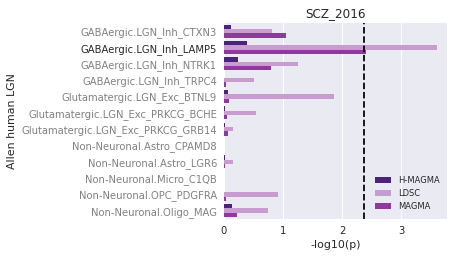

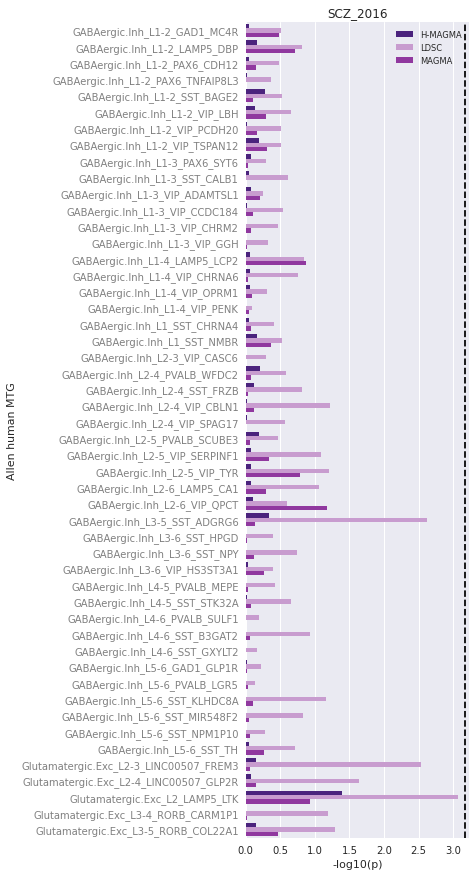

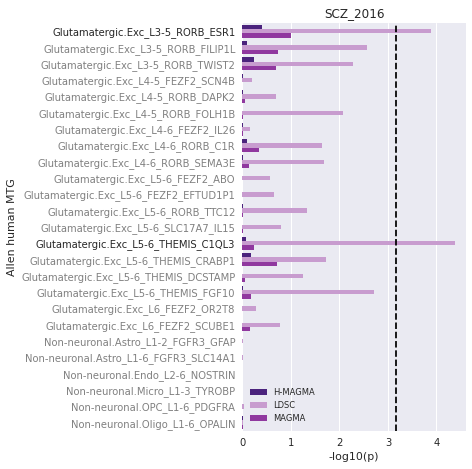

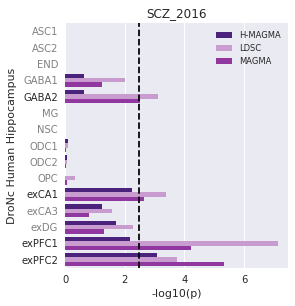

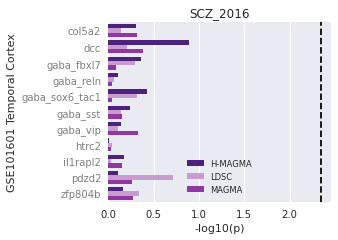

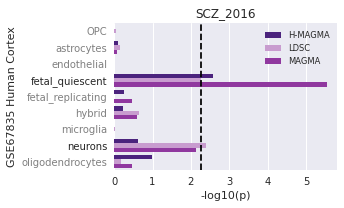

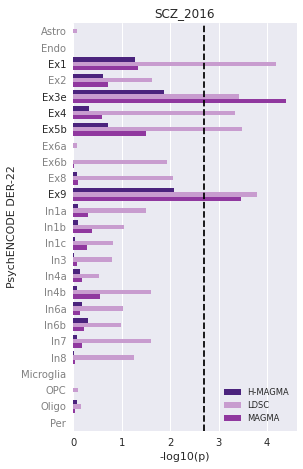

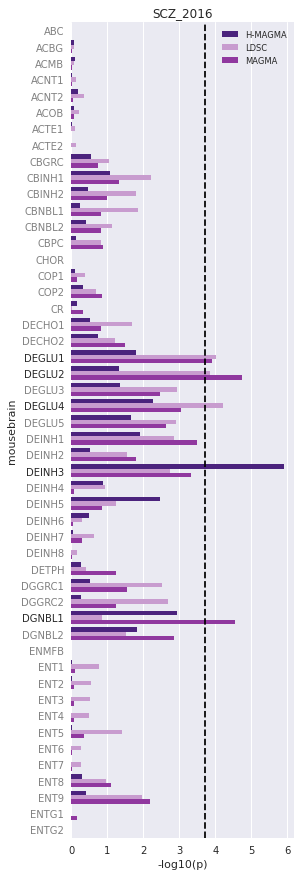

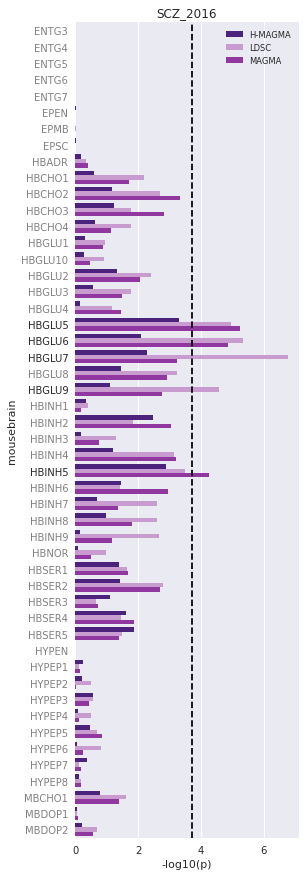

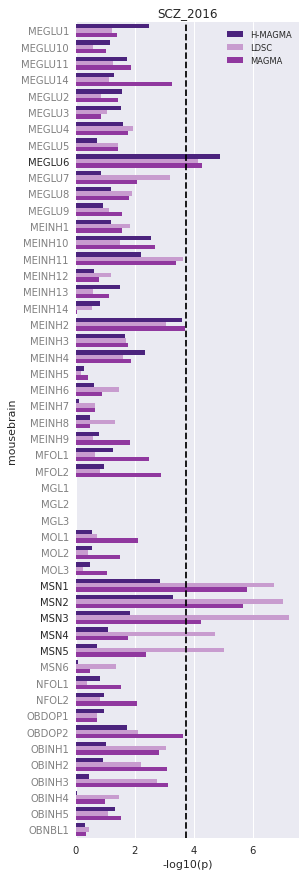

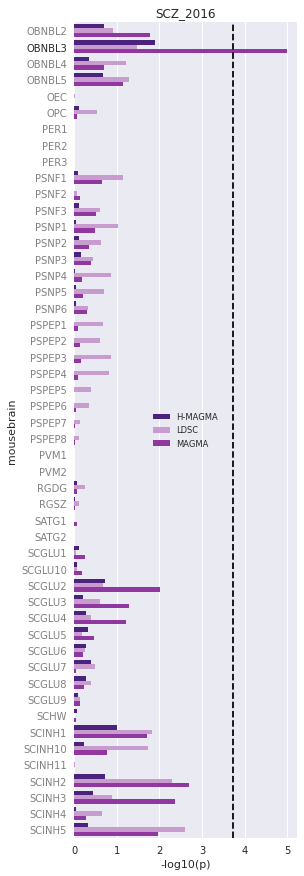

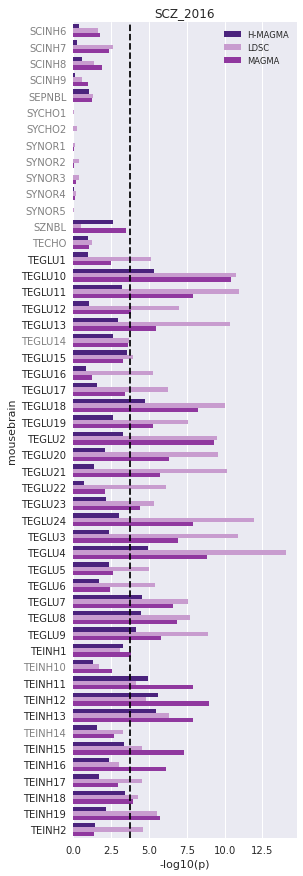

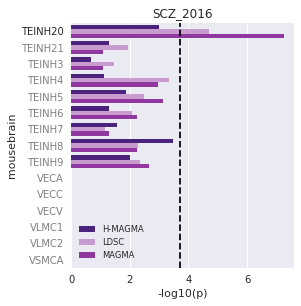

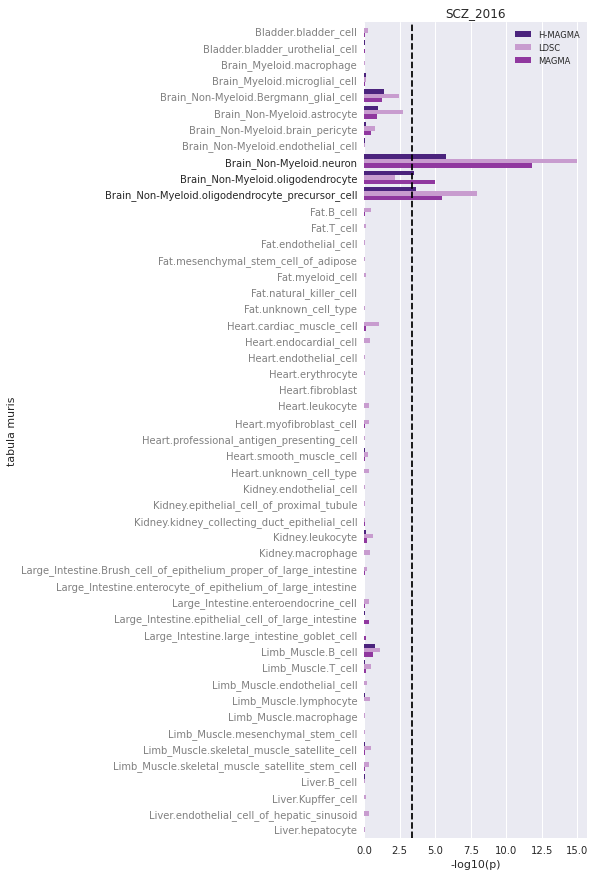

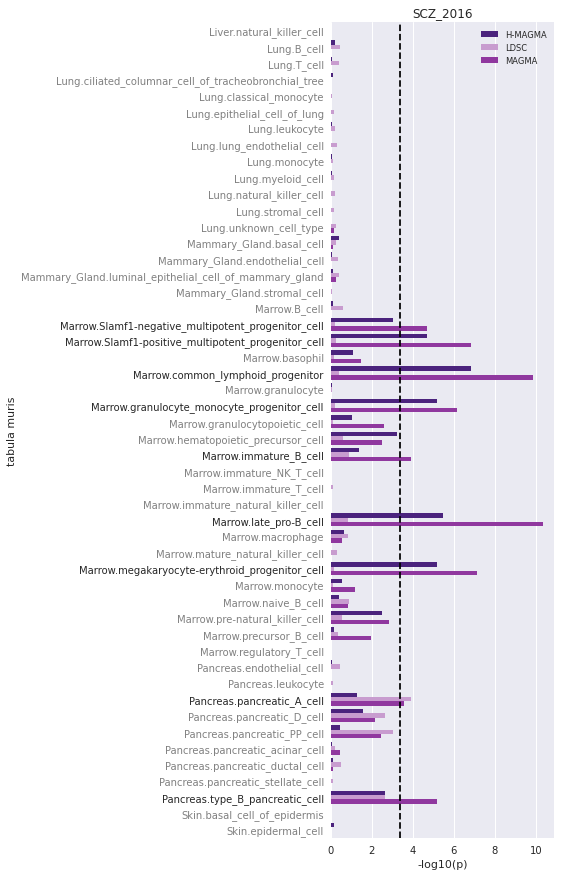

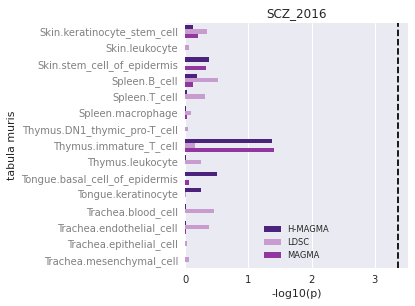

In [7]:
def barplot_annot(df_barplt):
    fig, ax  = plt.subplots(figsize=(4,.3*len(df_barplt.annotation.unique())))

    g = sns.barplot(x='-log10(p)',y='annotation', hue='method', data=df_barplt, 
                palette=color
               )
    for tick in ax.get_yticklabels():
        if tick.get_text() not in sign_annot:
            tick.set_color('grey')


    plt.axvline(-np.log10(dataframe.pthres.unique()), linestyle='--', c='k')
    plt.legend(fontsize='small')
    plt.title(name)
    plt.ylabel(sp_id.replace('_',' '))
    
    return g

plt.style.use('seaborn')

specificity_ids = df_SCZ[(df_SCZ.gwas==name)].specificity_id.unique()
sign_annot = df_SCZ_sign[(df_SCZ_sign.gwas==name)].annotation.unique().tolist()
split_value = 50

for sp_id in specificity_ids:
       
    dataframe = df_SCZ[(df_SCZ.gwas==name)&(df_SCZ.specificity_id==sp_id)]
    methods = dataframe['method'].unique()
#     color = sns.color_palette("colorblind",len(methods))
    color = sns.color_palette(['#4A148C', '#CE93D8','#9C27B0'])
    
    N = int(len(dataframe)/(len(methods)*split_value))+1
    if N > 1:
        for n in range(N):
            df_barplt = dataframe.drop_duplicates(['annotation','method'], keep='first')\
                        .groupby('method').apply(lambda x: x.iloc[n*split_value:(n+1)*split_value])\
                        .reset_index(level=0, drop=True)
            barplot_annot(df_barplt)
#             plt.savefig(f"{out_dir}{name}/associated_annotation_{sp_id}{n}_{name}.png", dpi=200, bbox_inches='tight')
            plt.show()
    else:
        barplot_annot(dataframe) 
#         plt.savefig(f"{out_dir}{name}/associated_annotation_{sp_id}_{name}.png", dpi=200, bbox_inches='tight')
        plt.show()
#     break

### Plot venn diagrams of the shared associated annotations between methods

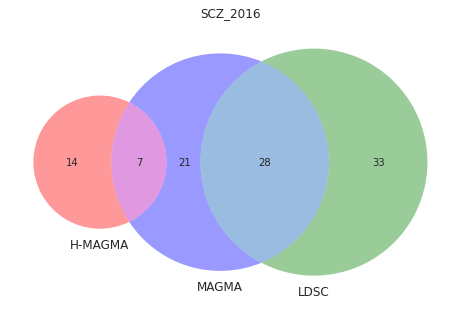

In [8]:
methods = df_SCZ_sign[(df_SCZ_sign.gwas=='SCZ_2016')].method.unique()
col_list = ['gwas','specificity_id','annotation']
c = {m:len(df_SCZ_sign[(df_SCZ_sign.gwas=='SCZ_2016')][df_SCZ_sign[(df_SCZ_sign.gwas=='SCZ_2016')]['method']==m]) for m in methods}
df_venn = df_SCZ_sign[(df_SCZ_sign.gwas=='SCZ_2016')].groupby(col_list,as_index=False)['method'].agg('sum')
m01 = df_venn[(df_venn['method']==methods[0]+methods[1])|(df_venn['method']==methods[1]+methods[0])] 
m02 = df_venn[(df_venn['method']==methods[0]+methods[2])|(df_venn['method']==methods[2]+methods[0])] 
m12 = df_venn[(df_venn['method']==methods[1]+methods[2])|(df_venn['method']==methods[2]+methods[1])] 
m012 = df_venn[(df_venn['method']==methods[1]+methods[2]+methods[0])] #edit so it sees all possabilities
c[f'{methods[0]}_{methods[1]}'] = len(m01)
c[f'{methods[0]}_{methods[2]}'] = len(m02)
c[f'{methods[1]}_{methods[2]}'] = len(m12)
c[f'{methods[0]}_{methods[1]}_{methods[2]}'] = len(m012)
M = methods
v = venn3(subsets = (c[M[0]]-c[f'{M[0]}_{M[1]}']-c[f'{M[0]}_{M[2]}']+c[f'{M[0]}_{M[1]}_{M[2]}'],
                     c[M[1]]-c[f'{M[1]}_{M[2]}']-c[f'{M[0]}_{M[1]}']+c[f'{M[0]}_{M[1]}_{M[2]}'],
                     c[f'{M[0]}_{M[1]}'],
                     c[M[2]]-c[f'{M[0]}_{M[2]}']-c[f'{M[1]}_{M[2]}']+c[f'{M[0]}_{M[1]}_{M[2]}'],
                     c[f'{M[0]}_{M[2]}'], c[f'{M[1]}_{M[2]}'], c[f'{M[0]}_{M[1]}_{M[2]}']), 
          set_labels = (methods))
# change the colors...
# v.get_patch_by_id('100').set_color('#4A148C')
# v.get_patch_by_id('110').set_color('#9C27B0')
# v.get_patch_by_id('010').set_color('#CE93D8')
# v.get_patch_by_id('001').set_color('#9C27B0')
# v.get_patch_by_id('011').set_color('#4A148C')
# v.get_patch_by_id('111').set_color('#')
plt.title(name)
plt.show()
# plt.savefig(f"{out_dir}venn_methods_significant_annot.png", dpi=200)

In [9]:
df_venn

gwas           specificity_id  \
0   SCZ_2016          Allen_human_LGN   
1   SCZ_2016          Allen_human_MTG   
2   SCZ_2016          Allen_human_MTG   
3   SCZ_2016  DroNc_Human_Hippocampus   
4   SCZ_2016  DroNc_Human_Hippocampus   
..       ...                      ...   
72  SCZ_2016             tabula_muris   
73  SCZ_2016             tabula_muris   
74  SCZ_2016             tabula_muris   
75  SCZ_2016             tabula_muris   
76  SCZ_2016             tabula_muris   

                                        annotation        method  
0                          GABAergic.LGN_Inh_LAMP5     LDSCMAGMA  
1                 Glutamatergic.Exc_L3-5_RORB_ESR1          LDSC  
2              Glutamatergic.Exc_L5-6_THEMIS_C1QL3          LDSC  
3                                            GABA2     LDSCMAGMA  
4                                            exCA1     LDSCMAGMA  
..                                             ...           ...  
72                          Marrow.immature_B_cell         MAGMA  
73                          Marrow.late_pro-B_cell  H-MAGMAMAGMA  
74  Marrow.megakaryocyte-erythroid_progenitor_cell  H-MAGMAMAGMA  
75                      Pancreas.pancreatic_A_cell     LDSCMAGMA  
76                 Pancreas.type_B_pancreatic_cell         MAGMA  

[77 rows x 4 columns]

### Plot beta histogram for all annotations

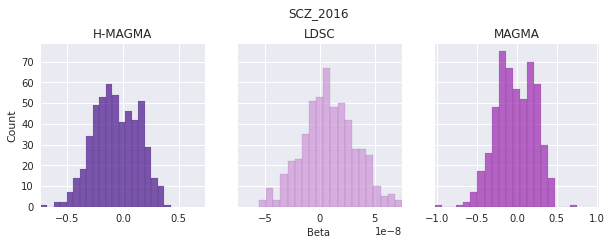

In [117]:
plt.style.use('seaborn')

specificity_ids = df_SCZ[(df_SCZ.gwas=='SCZ_2016')].specificity_id.unique()
sign_annot = df_SCZ_sign[(df_SCZ_sign.gwas=='SCZ_2016')].annotation.unique().tolist()

dataframe = df_SCZ[(df_SCZ.gwas=='SCZ_2016')]
methods = dataframe['method'].unique()
#     color = sns.color_palette("colorblind",len(methods))
color = sns.color_palette(['#4A148C', '#CE93D8','#9C27B0'], len(methods))
# df_beta = dataframe.pivot_table(index=['specificity_id','annotation'], columns='method', values='beta')
fig, ax  = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharey=True)
for i, (m,c) in enumerate(zip(methods, color)):
    df_hist =  dataframe[dataframe.method==m]['beta']
    df_hist.hist(bins=20, label=m, color=c, ax=ax[i], alpha=.7, edgecolor='black', lw=.1)
    ax[i].set_title(m)
    lim = df_hist.abs().max()
    ax[i].set_xlim(left=-lim, right=lim)
ax[0].set_ylabel('Count')
plt.suptitle(name,x=.51, y=1.05)
fig.text(0.51, -0.01, 'Beta',  horizontalalignment='center')
plt.show()

In [ ]:
df_all

In [132]:
phenotypes = {
            "Frontal": ["superiorfrontal", "rostralmiddlefrontal", "caudalmiddlefrontal", "parsopercularis", "parstriangularis","parsorbitalis", "lateralorbitofrontal", "medialorbitofrontal", "precentral", "paracentral", "frontalpole"],
            "Temporal": ["superiortemporal", "middletemporal", "inferiortemporal", "bankssts", "fusiform", "transversetemporal","entorhinal", "temporalpole", "parahippocampal"],
            "Parietal": ["superiorparietal", "inferiorparietal", "supramarginal", "postcentral", "precuneus"  ],
            "Occipital": ["lateraloccipital", "lingual", "cuneus", "pericalcarine"],
            "Cingulate": ["rostralanteriorcingulate", "caudalanteriorcingulate", "posteriorcingulate", "isthmuscingulate"],
            "Insula": ["insula"],  
            "Cortex": ['cortex']
            }
model = {
        "model1a": "surface area",
        "model1b": "cortical thickness\n(adjusted for global thickness)",
        "model1c": "cortical thickness",
        "model1d": "volume" 
        }
namecort = 'cortical_ROI_CHARGE2020'
priori_dict = make_df(files_dir)

inv_map_pheno = {v:k for k,v_list in phenotypes.items() for v in v_list}

# for names, dataframe in priori_dict.items():
#     if names==namecort:
#         df_cort = dataframe
df_cort = df_all[df_all.gwas.str.startswith('model')==True]
gwas_list = df_cort['gwas'].unique()
methods = df_cort['method'].unique()

df_cort[['model', 'sub_region']] = df_cort.gwas.str.split('_',expand=True)
df_cort = df_cort.assign(region=[inv_map_pheno[sr] for sr in df_cort.sub_region])
# df_cort.loc[:,'region'] = [inv_map_pheno[sr] for sr in df_cort.sub_region]
df_cort_vol = df_cort[df_cort['model']=='model1d']
df_cort_sa = df_cort[df_cort['model']=='model1a']
df_cort_th = df_cort[df_cort['model']=='model1b']


In [131]:
df_cort.model.unique()

array(['model1a', 'model1b', 'model1d'], dtype=object)

In [120]:
df_SCZ16_sign = df_SCZ_sign[(df_SCZ_sign.gwas=='SCZ_2016')]
df_SCZ16 = df_SCZ[(df_SCZ.gwas=='SCZ_2016')]
df_SCZ16_mb = df_SCZ16[df_SCZ16.specificity_id=='mousebrain']
df_SCZ16_mb

gwas specificity_id annotation      beta   beta_se    pvalue  \
349328  SCZ_2016     mousebrain        ABC -0.287857  0.068626  0.999986   
349329  SCZ_2016     mousebrain       ACBG -0.070738  0.075944  0.824179   
349330  SCZ_2016     mousebrain       ACMB -0.051890  0.064734  0.788594   
349331  SCZ_2016     mousebrain      ACNT1 -0.111495  0.070102  0.944123   
349332  SCZ_2016     mousebrain      ACNT2 -0.025439  0.066874  0.648174   
...          ...            ...        ...       ...       ...       ...   
350642  SCZ_2016     mousebrain       VECC -0.354764  0.065653  1.000000   
350643  SCZ_2016     mousebrain       VECV -0.228171  0.062454  0.999870   
350644  SCZ_2016     mousebrain      VLMC1 -0.371154  0.076810  0.999999   
350645  SCZ_2016     mousebrain      VLMC2 -0.294629  0.069104  0.999990   
350646  SCZ_2016     mousebrain      VSMCA -0.406072  0.075026  1.000000   

         method     -log10(p)  n_methods  n_annotations    pthres  
349328  H-MAGMA  5.974134e-06          3            265  0.000189  
349329  H-MAGMA  8.397867e-02          3            265  0.000189  
349330  H-MAGMA  1.031463e-01          3            265  0.000189  
349331  H-MAGMA  2.497145e-02          3            265  0.000189  
349332  H-MAGMA  1.883082e-01          3            265  0.000189  
...         ...           ...        ...            ...       ...  
350642    MAGMA  1.441007e-08          3            265  0.000189  
350643    MAGMA  5.639867e-05          3            265  0.000189  
350644    MAGMA  2.964211e-07          3            265  0.000189  
350645    MAGMA  4.396474e-06          3            265  0.000189  
350646    MAGMA  1.372235e-08          3            265  0.000189  

[795 rows x 11 columns]

In [133]:
df_SCZ16_mb_sign = df_SCZ16_mb[(df_SCZ16_mb.pvalue <= df_SCZ16_mb.pthres)]
df_cort_vol_sign = df_cort_vol[(df_cort_vol.pvalue <= df_cort_vol.pthres)]
df_cort_sa_sign = df_cort_sa[(df_cort_sa.pvalue <= df_cort_sa.pthres)]
df_cort_th_sign = df_cort_th[(df_cort_th.pvalue <= df_cort_th.pthres)]

df_cort_vol_sign

gwas specificity_id annotation          beta  \
421102                model1d_cuneus     mousebrain       RGDG  7.928595e-08   
435095         model1d_pericalcarine     mousebrain      MFOL1  1.493581e-01   
435096         model1d_pericalcarine     mousebrain      MFOL2  2.019232e-01   
435776           model1d_postcentral     mousebrain     CBNBL2  2.644130e-01   
436306           model1d_postcentral     mousebrain     CBNBL2  2.589938e-01   
436336           model1d_postcentral     mousebrain       ENT4  1.774018e-01   
436346           model1d_postcentral     mousebrain      ENTG5  1.485392e-01   
440426  model1d_rostralmiddlefrontal     mousebrain       PER2  1.510225e-01   
442011      model1d_superiorparietal     mousebrain     OBNBL4  2.865971e-01   
442084      model1d_superiorparietal     mousebrain     TEGLU2  1.898511e-01   
443152         model1d_supramarginal     mousebrain     TEGLU5  1.904096e-01   

             beta_se    pvalue   method  -log10(p)  n_methods  n_annotations  \
421102  2.174951e-08  0.000133     LDSC   3.874579          3            265   
435095  4.171557e-02  0.000172  H-MAGMA   3.764163          3            265   
435096  4.397177e-02  0.000002  H-MAGMA   5.654995          3            265   
435776  7.084933e-02  0.000095  H-MAGMA   4.020714          3            265   
436306  7.220865e-02  0.000168    MAGMA   3.774760          3            265   
436336  4.535257e-02  0.000046    MAGMA   4.336761          3            265   
436346  4.021010e-02  0.000111    MAGMA   3.955647          3            265   
440426  4.020832e-02  0.000087    MAGMA   4.062155          3            265   
442011  7.461591e-02  0.000062    MAGMA   4.210853          3            265   
442084  4.905507e-02  0.000055    MAGMA   4.262637          3            265   
443152  4.980544e-02  0.000066  H-MAGMA   4.179226          3            265   

          pthres    model            sub_region     region  
421102  0.000189  model1d                cuneus  Occipital  
435095  0.000189  model1d         pericalcarine  Occipital  
435096  0.000189  model1d         pericalcarine  Occipital  
435776  0.000189  model1d           postcentral   Parietal  
436306  0.000189  model1d           postcentral   Parietal  
436336  0.000189  model1d           postcentral   Parietal  
436346  0.000189  model1d           postcentral   Parietal  
440426  0.000189  model1d  rostralmiddlefrontal    Frontal  
442011  0.000189  model1d      superiorparietal   Parietal  
442084  0.000189  model1d      superiorparietal   Parietal  
443152  0.000189  model1d         supramarginal   Parietal

In [135]:
SCZ_annot_list = df_SCZ16_mb_sign.annotation.to_list()

cortvol_annot_list = df_cort_vol_sign.annotation.to_list()
cortsa_annot_list = df_cort_sa_sign.annotation.to_list()
cortth_annot_list = df_cort_th_sign.annotation.to_list()
print('\t'.join(SCZ_annot_list),'\n\n', '\t'.join(cortvol_annot_list),
     '\n\n', '\t'.join(cortsa_annot_list), '\n\n', '\t'.join(cortth_annot_list))

DEINH3	MEGLU6	TEGLU10	TEGLU18	TEGLU4	TEGLU7	TEGLU8	TEGLU9	TEINH11	TEINH12	TEINH13	DEGLU1	DEGLU2	DEGLU4	HBGLU5	HBGLU6	HBGLU7	HBGLU9	MEGLU6	MSN1	MSN2	MSN3	MSN4	MSN5	TEGLU1	TEGLU10	TEGLU11	TEGLU12	TEGLU13	TEGLU15	TEGLU16	TEGLU17	TEGLU18	TEGLU19	TEGLU2	TEGLU20	TEGLU21	TEGLU22	TEGLU23	TEGLU24	TEGLU3	TEGLU4	TEGLU5	TEGLU6	TEGLU7	TEGLU8	TEGLU9	TEINH11	TEINH12	TEINH13	TEINH15	TEINH17	TEINH18	TEINH19	TEINH2	TEINH20	DEGLU1	DEGLU2	DGNBL1	HBGLU5	HBGLU6	HBINH5	MEGLU6	MSN1	MSN2	MSN3	OBNBL3	TEGLU10	TEGLU11	TEGLU12	TEGLU13	TEGLU18	TEGLU19	TEGLU2	TEGLU20	TEGLU21	TEGLU23	TEGLU24	TEGLU3	TEGLU4	TEGLU7	TEGLU8	TEGLU9	TEINH1	TEINH11	TEINH12	TEINH13	TEINH15	TEINH16	TEINH18	TEINH19	TEINH20 

 RGDG	MFOL1	MFOL2	CBNBL2	CBNBL2	ENT4	ENTG5	PER2	OBNBL4	TEGLU2	TEGLU5 

 ENTG4	MFOL1	MFOL2	NFOL1	NFOL2	SCGLU10	SCGLU9	VLMC2	OEC	SZNBL	VLMC2	SCINH5 

 VLMC1	MFOL2	MFOL2	MOL1	MFOL1	MEINH14	CBNBL2	CBNBL2	OEC	ACNT1	TEGLU5


In [324]:
name

'SCZ_2016'

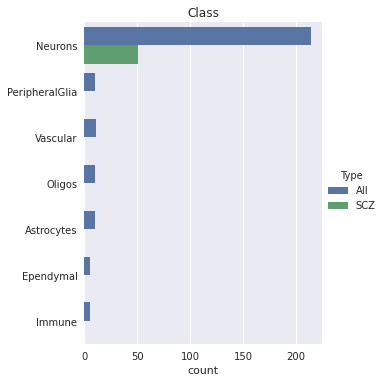

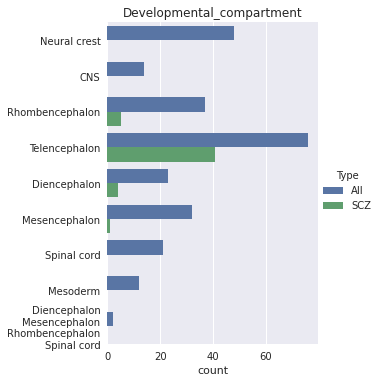

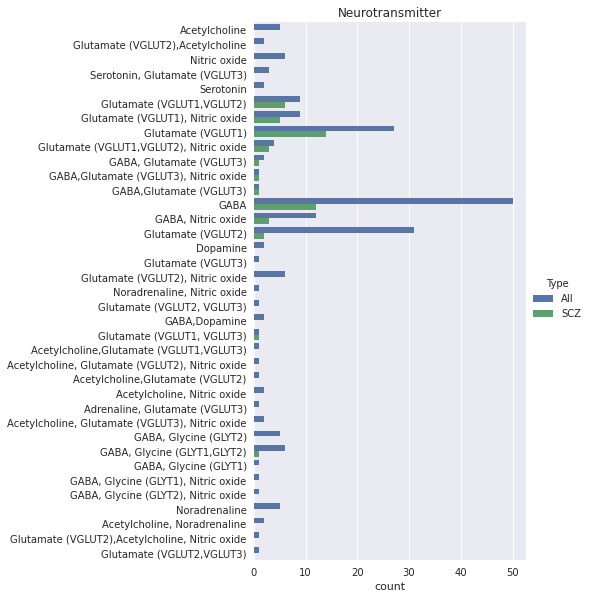

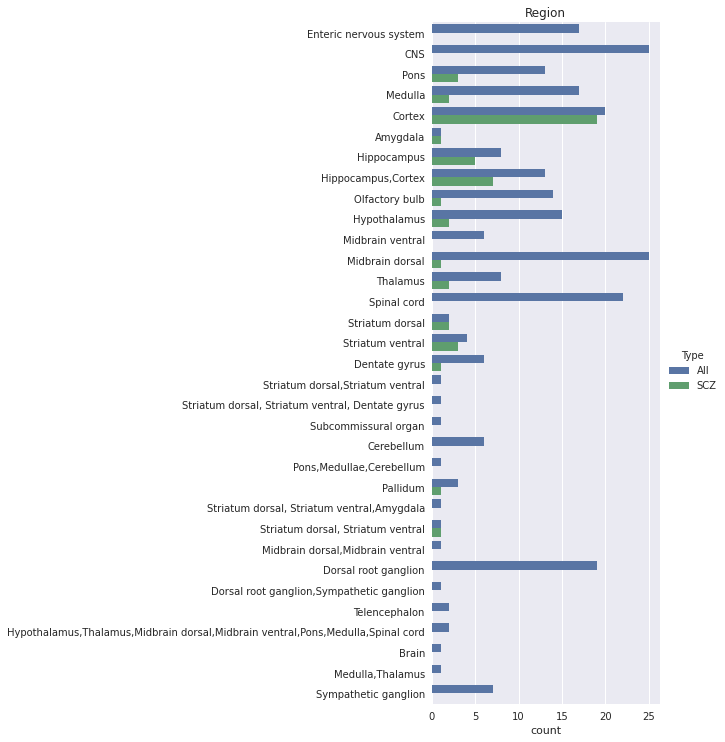

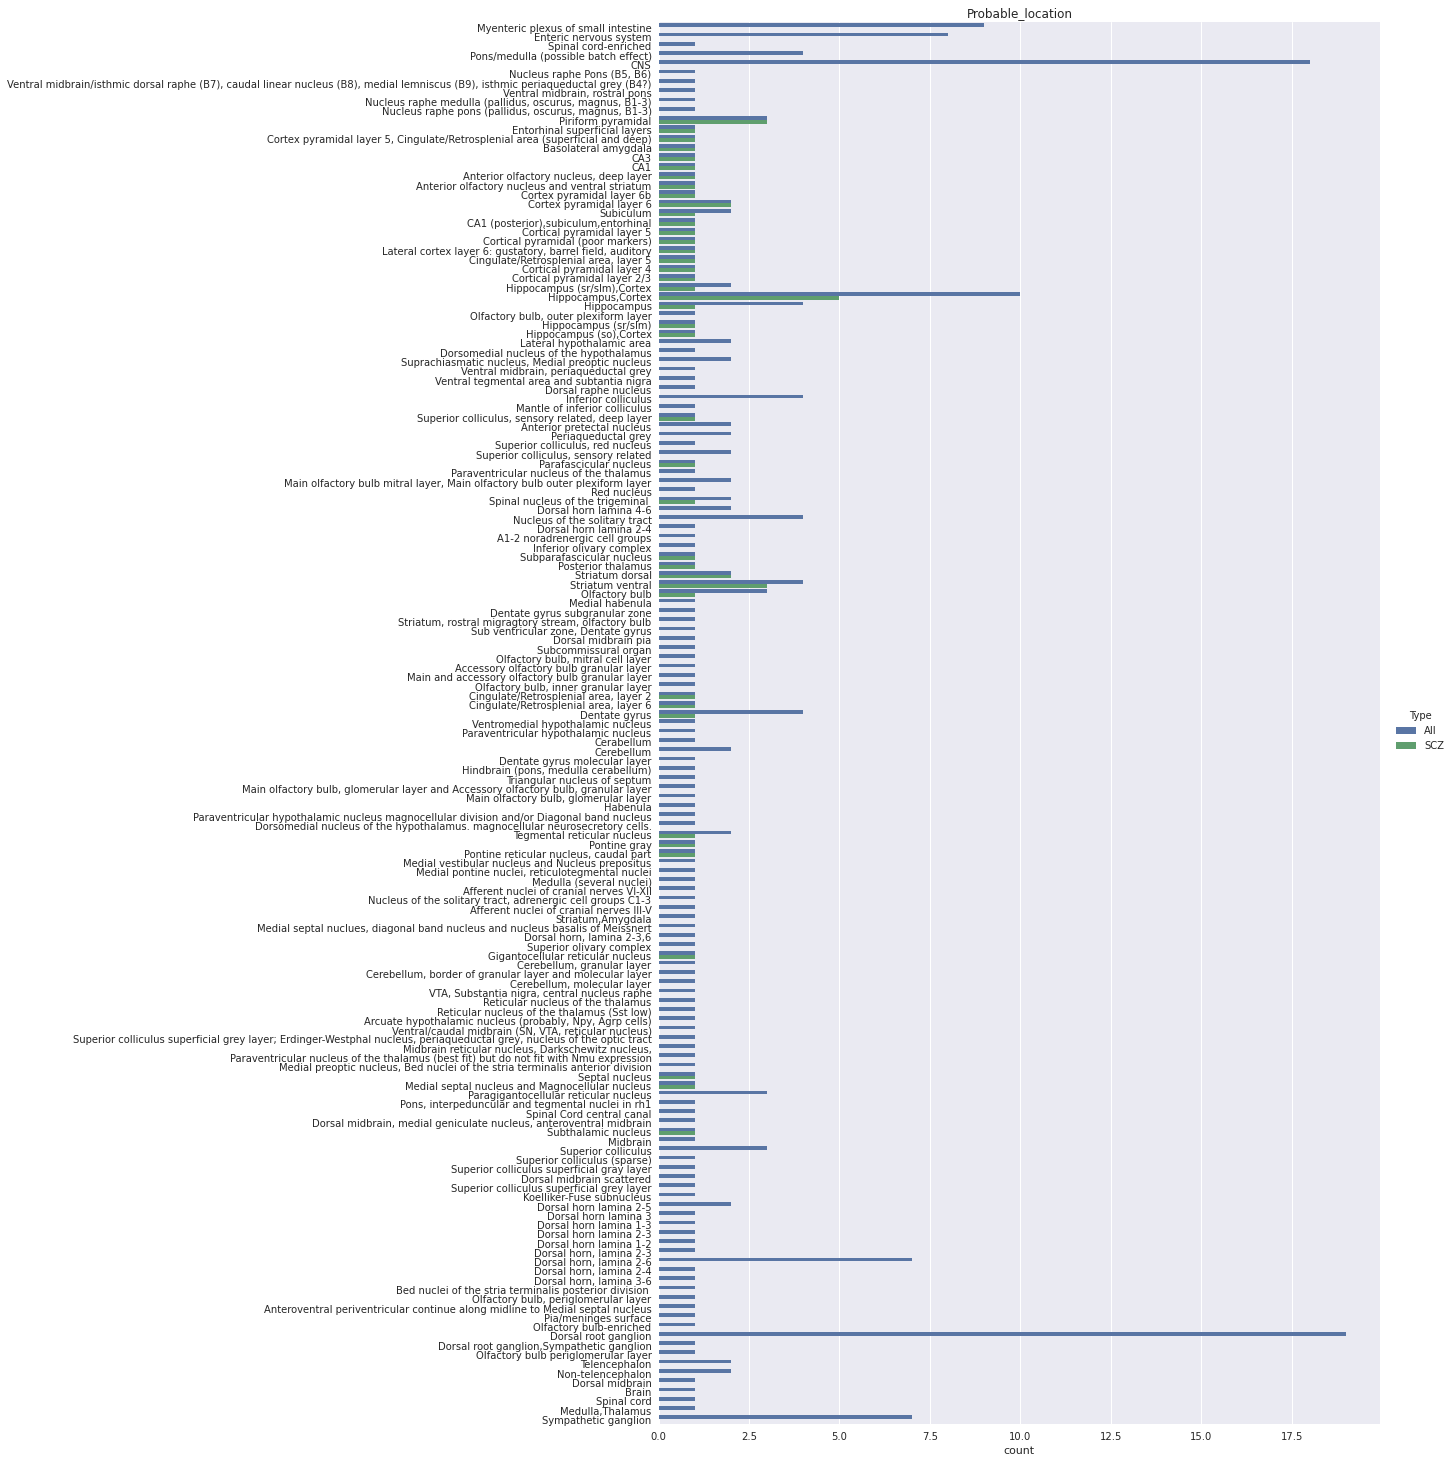

In [325]:
#use mousebrain metadata to infer more info
SCZ_annot_list
file = "/home/eerdem/notebooks/CELLECT-Analyser/mousebrain_celltype_metadata.csv"
mb_metadata_df = pd.read_csv(file)
SCZ_sign_annot_df = mb_metadata_df[mb_metadata_df.ClusterName.isin(SCZ_annot_list)]

mb_metadata_df['Type'] = 'All'
temp_df = mb_metadata_df[mb_metadata_df.ClusterName.isin(SCZ_annot_list)]
temp_df.Type = 'SCZ'
mb_SCZ_concat_df = pd.concat([mb_metadata_df,temp_df])
mb_SCZ_concat_df.Developmental_compartment.replace('Diencephalon,Mesencephalon,Rhombencephalon,Spinal cord',
                                                  'Diencephalon,Mesencephalon,Rhombencephalon,Spinal cord'.replace(',','\n'),
                                                   inplace=True)

ylab = ["Class", "Developmental_compartment", "Neurotransmitter","Region", "Probable_location"]
heights = [5,5,8,10,20]
for height,y in zip(heights,ylab):            
    sns.catplot(y=y, kind="count", hue="Type", data=mb_SCZ_concat_df, height=height)
    plt.ylabel('')
    plt.title(y)
    plt.savefig(f"{out_dir}{name}/{name}_mousebrain_{y}.png", dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [145]:
df_cort_th_sign

gwas specificity_id annotation          beta  \
392036  model1b_caudalmiddlefrontal     mousebrain      VLMC1  2.250330e-01   
392166               model1b_cortex     mousebrain      MFOL2  1.537690e-01   
392696               model1b_cortex     mousebrain      MFOL2  2.178229e-01   
392700               model1b_cortex     mousebrain       MOL1  1.983375e-01   
403295          model1b_paracentral     mousebrain      MFOL1  1.336708e-01   
406466     model1b_parstriangularis     mousebrain    MEINH14  3.007278e-01   
407951          model1b_postcentral     mousebrain     CBNBL2  2.772963e-01   
408481          model1b_postcentral     mousebrain     CBNBL2  2.693830e-01   
414188     model1b_superiorparietal     mousebrain        OEC  1.566186e-01   
416157         model1b_temporalpole     mousebrain      ACNT1  7.078160e-08   
417182   model1b_transversetemporal     mousebrain     TEGLU5  6.683210e-08   

             beta_se        pvalue   method  -log10(p)  n_methods  \
392036  4.683368e-02  7.818045e-07    MAGMA   6.106902          3   
392166  4.316478e-02  1.843799e-04  H-MAGMA   3.734286          3   
392696  4.398900e-02  3.718983e-07    MAGMA   6.429576          3   
392700  4.854674e-02  2.211064e-05    MAGMA   4.655399          3   
403295  3.751404e-02  1.837784e-04  H-MAGMA   3.735706          3   
406466  8.078737e-02  9.903408e-05  H-MAGMA   4.004215          3   
407951  6.952184e-02  3.339912e-05  H-MAGMA   4.476265          3   
408481  7.014868e-02  6.173738e-05    MAGMA   4.209452          3   
414188  4.382489e-02  1.765370e-04    MAGMA   3.753164          3   
416157  1.950626e-08  1.424478e-04     LDSC   3.846344          3   
417182  1.752146e-08  6.828510e-05     LDSC   4.165674          3   

        n_annotations    pthres    model           sub_region    region  
392036            265  0.000189  model1b  caudalmiddlefrontal   Frontal  
392166            265  0.000189  model1b               cortex    Cortex  
392696            265  0.000189  model1b               cortex    Cortex  
392700            265  0.000189  model1b               cortex    Cortex  
403295            265  0.000189  model1b          paracentral   Frontal  
406466            265  0.000189  model1b     parstriangularis   Frontal  
407951            265  0.000189  model1b          postcentral  Parietal  
408481            265  0.000189  model1b          postcentral  Parietal  
414188            265  0.000189  model1b     superiorparietal  Parietal  
416157            265  0.000189  model1b         temporalpole  Temporal  
417182            265  0.000189  model1b   transversetemporal  Temporal

In [143]:
print('Volume:\n','\t'.join([a for a in SCZ_annot_list if a in cortvol_annot_list]))
print('Surface Area:\n','\t'.join([a for a in SCZ_annot_list if a in cortsa_annot_list]))
print('Thickness:\n','\t'.join([a for a in SCZ_annot_list if a in cortth_annot_list]))

Volume:
 TEGLU2	TEGLU5	TEGLU2
Surface Area:
 
Thickness:
 TEGLU5


The TEGLU2 and TEGLU5 celltypes are associated in both Schizophrenia and the volume of superiorparietal and supramarginal gyrus, respectively in the parietal lobe.
In the literature a decrease in volume in the superiorparietal and supramarginal is also observed in SCZ (https://pubmed.ncbi.nlm.nih.gov/22265363/, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2846293/).

### Gene Set Analysis

In [116]:
cellex_mousebrain_file = '/home/eerdem/CELLECT/example/CELLEX_DATA/mousebrain.mu.csv'
df_mb = pd.read_csv(cellex_mousebrain_file, index_col=0)
df_mb

ABC  ACBG      ACMB     ACNT1     ACNT2      ACOB  \
gene                                                                      
ENSG00000141668  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
ENSG00000204624  0.000000   0.0  0.949809  0.316275  0.727773  0.903466   
ENSG00000187848  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
ENSG00000171522  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
ENSG00000183662  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
...                   ...   ...       ...       ...       ...       ...   
ENSG00000073169  0.000000   0.0  0.000000  0.033442  0.000000  0.000000   
ENSG00000148341  0.224816   0.0  0.000000  0.000000  0.000000  0.000000   
ENSG00000168288  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
ENSG00000160563  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
ENSG00000100519  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   

                    ACTE1     ACTE2     CBGRC    CBINH1  ...    TEINH6  \
gene                                                     ...             
ENSG00000141668  0.000000  0.000000  0.000000  0.000000  ...  0.845756   
ENSG00000204624  0.860336  0.716323  0.000000  0.716596  ...  0.513711   
ENSG00000187848  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
ENSG00000171522  0.000000  0.773686  0.000000  0.091054  ...  0.000000   
ENSG00000183662  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                   ...       ...       ...       ...  ...       ...   
ENSG00000073169  0.000000  0.025113  0.316259  0.000000  ...  0.000000   
ENSG00000148341  0.000000  0.000000  0.143149  0.000000  ...  0.000000   
ENSG00000168288  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
ENSG00000160563  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
ENSG00000100519  0.000000  0.000000  0.000000  0.000000  ...  0.000000   

                   TEINH7    TEINH8    TEINH9     VECA      VECC      VECV  \
gene                                                                         
ENSG00000141668  0.759446  0.901704  0.080394  0.00000  0.000000  0.000000   
ENSG00000204624  0.461592  0.000000  0.000000  0.00000  0.000000  0.000000   
ENSG00000187848  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
ENSG00000171522  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
ENSG00000183662  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
...                   ...       ...       ...      ...       ...       ...   
ENSG00000073169  0.000000  0.000000  0.000000  0.00069  0.000000  0.000000   
ENSG00000148341  0.073366  0.107524  0.122834  0.00000  0.000000  0.000000   
ENSG00000168288  0.029996  0.000000  0.007655  0.00000  0.000000  0.041965   
ENSG00000160563  0.000000  0.103873  0.163200  0.00000  0.000000  0.057365   
ENSG00000100519  0.141904  0.197238  0.246519  0.00000  0.090229  0.169333   

                 VLMC1  VLMC2  VSMCA  
gene                                  
ENSG00000141668    0.0    0.0    0.0  
ENSG00000204624    0.0    0.0    0.0  
ENSG00000187848    0.0    0.0    0.0  
ENSG00000171522    0.0    0.0    0.0  
ENSG00000183662    0.0    0.0    0.0  
...                ...    ...    ...  
ENSG00000073169    0.0    0.0    0.0  
ENSG00000148341    0.0    0.0    0.0  
ENSG00000168288    0.0    0.0    0.0  
ENSG00000160563    0.0    0.0    0.0  
ENSG00000100519    0.0    0.0    0.0  

[15071 rows x 265 columns]

In [146]:
import mygene
import gseapy as gp
from gseapy.plot import barplot, dotplot, gseaplot

celltype = 'TEGLU5'
ens = df_mb[[celltype]][df_mb[celltype]>0.4].sort_values(by=celltype).index.to_list()
mg = mygene.MyGeneInfo()
ginfo = mg.querymany(ens, scopes='ensembl.gene')
gene_list = [g['symbol'] for g in ginfo if 'symbol' in g]
names = gp.get_library_name() # default: Human

querying 1-1000...done.
Finished.
8 input query terms found no hit:
	['ENSG00000174111', 'ENSG00000196963', 'ENSG00000181039', 'ENSG00000161326', 'ENSG00000183473', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


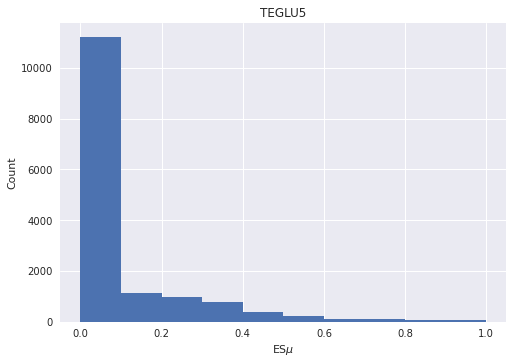

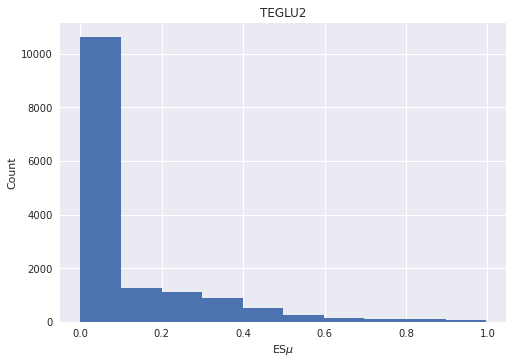

In [162]:
for t in ['TEGLU5', 'TEGLU2']:
    df_mb[t].hist()
    plt.title(t)
    plt.ylabel('Count')
    plt.xlabel(r'ES$\mu$')
    
    plt.show()

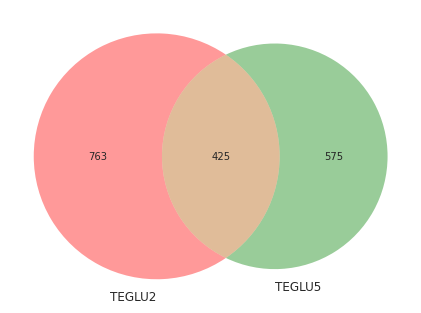

In [181]:
celltypes = ['TEGLU2','TEGLU5']
T2_genes = df_mb[[celltypes[0]]][df_mb[celltypes[0]]>0.4].sort_values(by=celltypes[0]).index.to_list()
T5_genes = df_mb[[celltypes[1]]][df_mb[celltypes[1]]>0.4].sort_values(by=celltypes[1]).index.to_list()
shared_genes = len(set(T2_genes)&set(T5_genes))
c = venn2(subsets = (len(T2_genes)-shared_genes, len(T5_genes)-shared_genes, shared_genes), 
              set_labels = celltypes)
plt.show()

In [ ]:
df_mb[[celltype]].sort_values(by=celltype).plot(kind='hist')

In [115]:
names

NameError: name 'names' is not defined

In [ ]:
gwas = 'SCZ_2016'
# gene_sets = 'Jensen_DISEASES'
# gene_sets = 'Reactome_2016'
# gene_sets = 'GO_Biological_Process_2018'
# gene_sets = 'GWAS_Catalog_2019'
# gene_sets = 'UK_Biobank_GWAS_v1'
# gene_sets = 'BioCarta_2016'
Path(f'{out_dir}{gwas}/{celltype}/').mkdir(parents=True, exist_ok=True)
for gene_sets in names:
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets=gene_sets,
                     outdir=f'test/enrichr_{gwas}_{gene_sets}',
                    )
    dotplot(enr.res2d, title=f'{celltype}\nGene-set:{gene_sets}',
            ofname=f"{out_dir}{gwas}/{celltype}/{gwas}_enrichr_{gene_sets}_{celltype}.png")

# enr.results[enr.results['Adjusted P-value']<0.05]

### Correlation

In [10]:
df_all_sign

gwas   specificity_id  \
532               InstantCoffee_2019  Allen_human_LGN   
533               InstantCoffee_2019  Allen_human_LGN   
784               InstantCoffee_2019       mousebrain   
808               InstantCoffee_2019       mousebrain   
809               InstantCoffee_2019       mousebrain   
...                              ...              ...   
436346           model1d_postcentral       mousebrain   
440426  model1d_rostralmiddlefrontal       mousebrain   
442011      model1d_superiorparietal       mousebrain   
442084      model1d_superiorparietal       mousebrain   
443152         model1d_supramarginal       mousebrain   

                               annotation          beta       beta_se  \
532      Glutamatergic.LGN_Exc_PRKCG_BCHE  3.064253e-09  1.056437e-09   
533     Glutamatergic.LGN_Exc_PRKCG_GRB14  3.027024e-09  1.102270e-09   
784                                MEGLU8  2.902296e-09  7.748866e-10   
808                                  MSN1  2.117390e-09  4.862612e-10   
809                                  MSN2  2.272184e-09  4.906751e-10   
...                                   ...           ...           ...   
436346                              ENTG5  1.485392e-01  4.021010e-02   
440426                               PER2  1.510225e-01  4.020832e-02   
442011                             OBNBL4  2.865971e-01  7.461591e-02   
442084                             TEGLU2  1.898511e-01  4.905507e-02   
443152                             TEGLU5  1.904096e-01  4.980544e-02   

          pvalue   method  -log10(p)  n_methods  n_annotations    pthres  
532     0.001863     LDSC   2.729901          3             12  0.004167  
533     0.003015     LDSC   2.520747          3             12  0.004167  
784     0.000090     LDSC   4.045581          3            265  0.000189  
808     0.000007     LDSC   5.175828          3            265  0.000189  
809     0.000002     LDSC   5.739477          3            265  0.000189  
...          ...      ...        ...        ...            ...       ...  
436346  0.000111    MAGMA   3.955647          3            265  0.000189  
440426  0.000087    MAGMA   4.062155          3            265  0.000189  
442011  0.000062    MAGMA   4.210853          3            265  0.000189  
442084  0.000055    MAGMA   4.262637          3            265  0.000189  
443152  0.000066  H-MAGMA   4.179226          3            265  0.000189  

[1842 rows x 11 columns]

In [61]:
# merge metadata
pd.options.mode.chained_assignment = None  # default='warn'
keep_col = df_all_sign.columns.tolist()
# keep_col.append('metadata')

#cortical
phenotypes_cort = {
            "Frontal": ["superiorfrontal", "rostralmiddlefrontal", "caudalmiddlefrontal", "parsopercularis", "parstriangularis","parsorbitalis", "lateralorbitofrontal", "medialorbitofrontal", "precentral", "paracentral", "frontalpole"],
            "Temporal": ["superiortemporal", "middletemporal", "inferiortemporal", "bankssts", "fusiform", "transversetemporal","entorhinal", "temporalpole", "parahippocampal"],
            "Parietal": ["superiorparietal", "inferiorparietal", "supramarginal", "postcentral", "precuneus"  ],
            "Occipital": ["lateraloccipital", "lingual", "cuneus", "pericalcarine"],
            "Cingulate": ["rostralanteriorcingulate", "caudalanteriorcingulate", "posteriorcingulate", "isthmuscingulate"],
            "Insula": ["insula"],  
            "Cortex": ['cortex']
            }
model_cort = {
        "model1a": "surface area",
        "model1b": "cortical thickness (adjusted for global thickness)",
        "model1c": "cortical thickness",
        "model1d": "volume" 
        }
inv_map_pheno = {v:k for k,v_list in phenotypes_cort.items() for v in v_list}
df_cort = df_all[df_all.gwas.str.contains('model1\w_\w+')]
df_drop = df_all.drop(df_cort.index)
df_cort[['model', 'sub_region']] = df_cort.gwas.str.split('_',expand=True)
df_cort = df_cort[df_cort['model']!='model1a']
df_cort['region'] = [inv_map_pheno[sr] for sr in df_cort.sub_region]
df_cort['model'] = [model_cort[m] for m in df_cort.model]
df_cort['gwas'] = df_cort[['model','region','sub_region']].apply(
                        lambda x: f'{x[0]}: {x[1]}.{x[2]}', axis=1)
df_cort = df_cort[keep_col]
#DTI
meta_dti = pd.read_csv('data/CELLECT/BIG-S2_DTI2020/DTI.csv', usecols=[0,1])
meta_dti[['type','pheno']] = meta_dti['assoc_files'].str.extract(r'_(\w+)_pheno(\d+)', expand=True)
DTI_params_dict = {'FA':'fractional anisotropy', 'MD':'mean diusivities',
                   'AD':'axial diusivities', 'RD':'radial diusivities', 'MO':'mode of anisotropy',
                   'PC1':'PC1', 'PC2':'PC2','PC3':'PC3','PC4':'PC4','PC5':'PC5'
                  }
WM_params_dict = {'ID':'Full Name','ACR':'Anterior corona radiata','ALIC':'Anterior limb of internal capsule',
                  'BCC':'Body of corpus callosum','CGC':'Cingulum (cingulate gyrus)',
                  'CGH':'Cingulum (hippocampus)','CST':'Corticospinal tract','EC':'External capsule',
                  'FX':'Fornix (column and body of fornix)',
                  'FXST':'Fornix (cres) / Stria terminalis (can not be resolved with current resolution)',
                  'GCC':'Genu of corpus callosum','IFO':'Inferior fronto-occipital fasciculus',
                  'PCR':'Posterior corona radiata','PLIC':'Posterior limb of internal capsule',
                  'PTR':'Posterior thalamic radiation (include optic radiation)',
                  'RLIC':'Retrolenticular part of internal capsule',
                  'SCC':'Splenium of corpus callosum','SCR':'Superior corona radiata',
                  'SFO':'Superior fronto-occipital fasciculus (could be a part of anterior internal capsule)',
                  'SLF':'Superior longitudinal fasciculus',
                  'SS':'Sagittal stratum (include inferior longitidinal fasciculus and inferior fronto-occipital fasciculus)',
                  'UNC':'Uncinate fasciculus','Average':'Whole brain average across all tracts}'}

df_dti = df_all[df_all.gwas.str.contains('ukb_phase1to3')]
df_drop.drop(df_dti.index, inplace=True)
df_dti[['type','pheno']] = df_dti['gwas'].str.extract(r'ukb_phase1to3_(\w+\d*)_dec21_2019_pheno(\d+)',expand=True)
df_dti = df_dti.replace({'type':{'dti441':'mean', 'fapcs':'fpc'}})
index_copy = df_dti.index
df_dti = pd.merge(df_dti, meta_dti, on=['type','pheno'])
df_dti[['WM_tract','DTI_param']] = df_dti['phenocode'].str.split('_', expand=True)
df_dti = df_dti[(df_dti['DTI_param']=='FA')|(df_dti['DTI_param']=='MD')]
df_dti['DTI_param'] = [DTI_params_dict[p] for p in df_dti.DTI_param]
df_dti['WM_tract'] = [WM_params_dict[p] for p in df_dti.WM_tract]
df_dti['gwas'] = df_dti[['WM_tract','DTI_param']].apply(
                        lambda x: f'{x[1]}: {x[0]}', axis=1)
df_dti = df_dti[keep_col]
# .set_index(index_copy)

#subcortical
df_subcor = df_all[df_all.gwas.str.contains('fixed_\w+_MEGAMETA')]
df_drop.drop(df_subcor.index, inplace=True)
df_subcor['gwas'] = 'volume: '+df_subcor.gwas.str.extract(r'fixed_(\w+)_MEGAMETA', expand=True)
df_subcor

df_meta_concat = pd.concat([df_cort, df_dti, df_subcor], ignore_index=False)
df_new = pd.concat([df_drop,df_meta_concat])
# df_all_sign['index'] = df_all_sign.index
# df_meta_concat['index'] = df_meta_concat.index
# df_all_sign_meta = df_all_sign.merge(df_meta_concat[['index','gwas']],how='left', on='index')\
#                     .drop('index',axis=1)



In [62]:
df_new[df_new.gwas=='InstantCoffee_2019']

gwas   specificity_id                   annotation  \
0     InstantCoffee_2019  Allen_human_LGN      GABAergic.LGN_Inh_CTXN3   
1     InstantCoffee_2019  Allen_human_LGN      GABAergic.LGN_Inh_LAMP5   
2     InstantCoffee_2019  Allen_human_LGN      GABAergic.LGN_Inh_NTRK1   
3     InstantCoffee_2019  Allen_human_LGN      GABAergic.LGN_Inh_TRPC4   
4     InstantCoffee_2019  Allen_human_LGN  Glutamatergic.LGN_Exc_BTNL9   
...                  ...              ...                          ...   
1576  InstantCoffee_2019     tabula_muris          Tongue.keratinocyte   
1577  InstantCoffee_2019     tabula_muris           Trachea.blood_cell   
1578  InstantCoffee_2019     tabula_muris     Trachea.endothelial_cell   
1579  InstantCoffee_2019     tabula_muris      Trachea.epithelial_cell   
1580  InstantCoffee_2019     tabula_muris     Trachea.mesenchymal_cell   

          beta   beta_se    pvalue   method  -log10(p)  n_methods  \
0    -0.014652  0.083502  0.569645  H-MAGMA   0.244396          3   
1    -0.036575  0.067650  0.705621  H-MAGMA   0.151428          3   
2    -0.093133  0.083124  0.868717  H-MAGMA   0.061122          3   
3     0.141324  0.093494  0.065336  H-MAGMA   1.184850          3   
4    -0.034171  0.125231  0.607518  H-MAGMA   0.216441          3   
...        ...       ...       ...      ...        ...        ...   
1576 -0.021438  0.048068  0.672198    MAGMA   0.172503          3   
1577 -0.123218  0.062713  0.975271    MAGMA   0.010875          3   
1578  0.107068  0.058867  0.034481    MAGMA   1.462422          3   
1579 -0.020384  0.055884  0.642355    MAGMA   0.192225          3   
1580  0.006711  0.046029  0.442039    MAGMA   0.354540          3   

      n_annotations    pthres  
0                12  0.004167  
1                12  0.004167  
2                12  0.004167  
3                12  0.004167  
4                12  0.004167  
...             ...       ...  
1576            115  0.000435  
1577            115  0.000435  
1578            115  0.000435  
1579            115  0.000435  
1580            115  0.000435  

[1581 rows x 11 columns]

In [63]:
df_all_mb = df_new[df_new.specificity_id=='mousebrain']
df_corr_dict_SCZ = {}
for m in methods:
    df_all_mb_m = df_all_mb[df_all_mb.method==m]
#     df_cort_vol_m = df_cort_vol_m.assign(meta=df_cort_vol_m['region']+':'+df_cort_vol_m['sub_region'])
#     df_c = df_cort_vol_m.pivot(index='annotation', columns='meta', values='beta')
    df_s = df_all_mb_m.pivot(index='annotation', columns='gwas', values='beta')
#     df_concat = pd.concat([df_c, df_s], axis=1, sort=False)

    df_corr = df_s.corr('spearman')[['SCZ_2016']]
    df_corr_dict_SCZ[m] = df_corr

In [64]:
df_SCZ_corr[a:b]

SCZ_2016\nH-MAGMA  \
volume:\tCingulate.\tcaudalanteriorcingulate           -0.271529   
volume:\tCingulate.\tisthmuscingulate                  -0.249957   
volume:\tCingulate.\tposteriorcingulate                -0.170619   
volume:\tCingulate.\trostralanteriorcingulate           0.077889   
volume:\tCortex.\tcortex                                0.100765   
volume:\tFrontal.\tcaudalmiddlefrontal                 -0.219213   
volume:\tFrontal.\tfrontalpole                         -0.155319   
volume:\tFrontal.\tlateralorbitofrontal                -0.092896   
volume:\tFrontal.\tmedialorbitofrontal                  0.058542   
volume:\tFrontal.\tparacentral                         -0.229278   
volume:\tFrontal.\tparsopercularis                     -0.046401   
volume:\tFrontal.\tparsorbitalis                       -0.133737   
volume:\tFrontal.\tparstriangularis                    -0.079840   
volume:\tFrontal.\tprecentral                           0.083504   
volume:\tFrontal.\trostralmiddlefrontal                -0.092597   
volume:\tFrontal.\tsuperiorfrontal                     -0.094520   
volume:\tInsula.\tinsula                                0.147368   
volume:\tOccipital.\tcuneus                            -0.196573   
volume:\tOccipital.\tlateraloccipital                   0.376444   
volume:\tOccipital.\tlingual                           -0.009508   
volume:\tOccipital.\tpericalcarine                     -0.037506   
volume:\tParietal.\tinferiorparietal                   -0.134830   
volume:\tParietal.\tpostcentral                        -0.093433   
volume:\tParietal.\tprecuneus                          -0.173215   
volume:\tParietal.\tsuperiorparietal                    0.074996   
volume:\tParietal.\tsupramarginal                       0.362473   
volume:\tTemporal.\tbankssts                           -0.251954   
volume:\tTemporal.\tentorhinal                         -0.015414   
volume:\tTemporal.\tfusiform                           -0.042396   
volume:\tTemporal.\tinferiortemporal                   -0.246003   
volume:\tTemporal.\tmiddletemporal                     -0.060682   
volume:\tTemporal.\tparahippocampal                     0.293216   
volume:\tTemporal.\tsuperiortemporal                    0.041326   
volume:\tTemporal.\ttemporalpole                        0.046808   
volume:\tTemporal.\ttransversetemporal                 -0.359770   
volume:accumbens                                       -0.479430   
volume:amygdala                                        -0.092319   
volume:caudate                                          0.275910   
volume:pallidum                                        -0.111835   
volume:putamen                                          0.166356   
volume:thalamus                                         0.302276   
AD_JANSEN2019                                                NaN   
BMI_GIANT2018                                                NaN   

                                               SCZ_2016\nLDSC  SCZ_2016\nMAGMA  
volume:\tCingulate.\tcaudalanteriorcingulate         0.197750         0.001955  
volume:\tCingulate.\tisthmuscingulate               -0.109983        -0.269239  
volume:\tCingulate.\tposteriorcingulate             -0.224056         0.135204  
volume:\tCingulate.\trostralanteriorcingulate       -0.212172         0.058910  
volume:\tCortex.\tcortex                             0.100183         0.152285  
volume:\tFrontal.\tcaudalmiddlefrontal              -0.000257        -0.125858  
volume:\tFrontal.\tfrontalpole                       0.119080        -0.088098  
volume:\tFrontal.\tlateralorbitofrontal             -0.300475        -0.036123  
volume:\tFrontal.\tmedialorbitofrontal               0.170942         0.160155  
volume:\tFrontal.\tparacentral                      -0.028263         0.148889  
volume:\tFrontal.\tparsopercularis                   0.268304         0.196854  
volume:\tFrontal.\tparsorbitalis                    -0.198545        -0.289938  
v

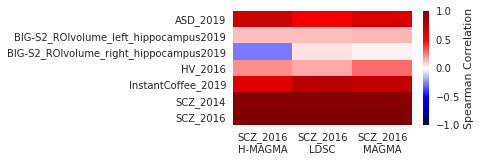

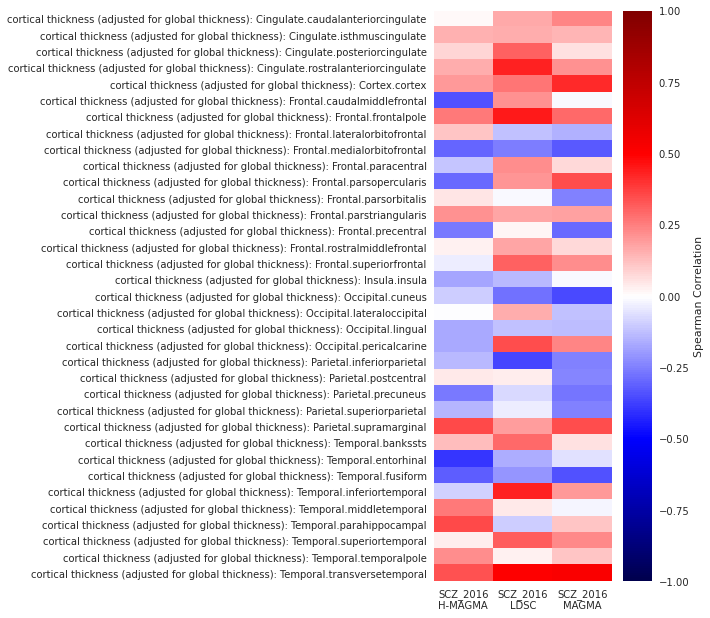

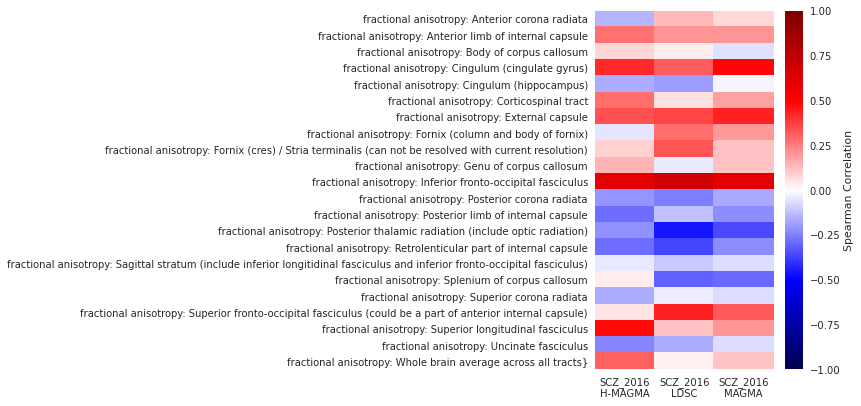

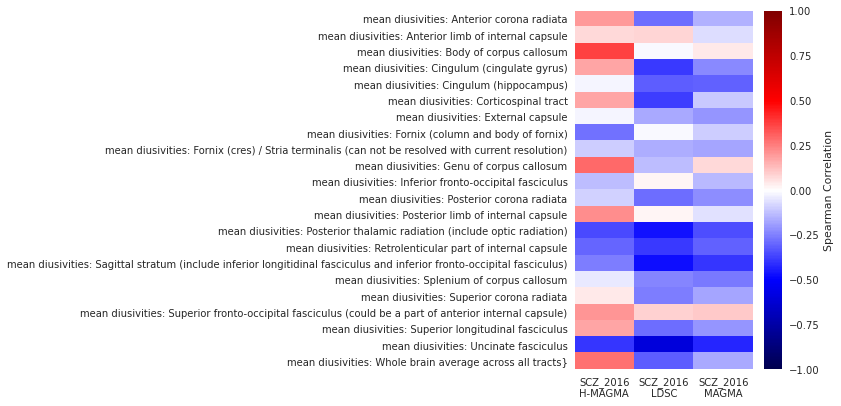

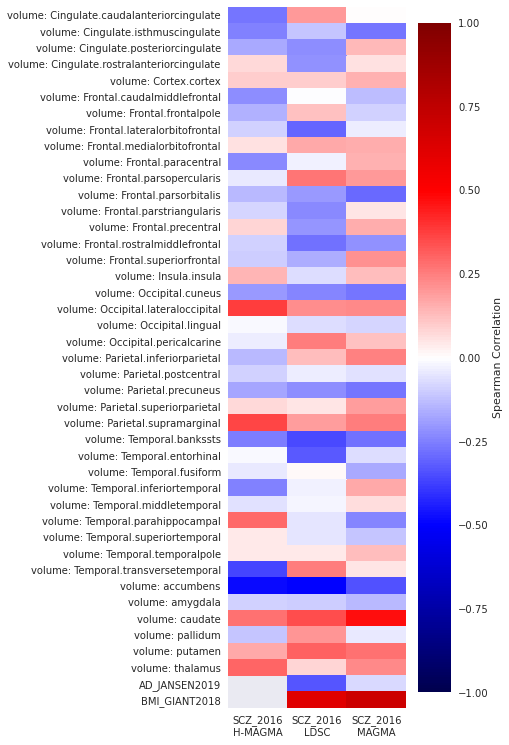

In [82]:
df_SCZ_corr = pd.concat([df_corr_dict_SCZ[m] for m in methods], axis=1)
df_SCZ_corr.columns = [f'SCZ_2016\n{m}' for m in methods]

for i,(a,b) in enumerate([[0,7],[7,42],[42,64],[64,86],[86,129]]):
    plt.figure(figsize=(4,(b-a)*.3))
    g = sns.heatmap(df_SCZ_corr[a:b], yticklabels=df_SCZ_corr[a:b].T.columns, xticklabels=df_SCZ_corr.columns,
                cmap="seismic",center=0, cbar_kws={'label': 'Spearman Correlation'},
                vmin=-1, vmax=1,annot=False,
                   )

    plt.savefig(f"{out_dir}/{name}/{name}_vs_all_correlation{i}.png", dpi=200, bbox_inches='tight')
    plt.show()


In [184]:
df_all_mb.gwas.unique()

array(['InstantCoffee_2019', 'HV_2016',
       'BIG-S2_ROIvolume_left_hippocampus2019',
       'BIG-S2_ROIvolume_right_hippocampus2019', 'SCZ_2014',
       'BMI_GIANT2018', 'AD_JANSEN2019', 'SCZ_2016', 'ASD_2019',
       'cortical thickness (adjusted for global thickness): Temporal.bankssts',
       'cortical thickness (adjusted for global thickness): Cingulate.caudalanteriorcingulate',
       'cortical thickness (adjusted for global thickness): Frontal.caudalmiddlefrontal',
       'cortical thickness (adjusted for global thickness): Cortex.cortex',
       'cortical thickness (adjusted for global thickness): Occipital.cuneus',
       'cortical thickness (adjusted for global thickness): Temporal.entorhinal',
       'cortical thickness (adjusted for global thickness): Frontal.frontalpole',
       'cortical thickness (adjusted for global thickness): Temporal.fusiform',
       'cortical thickness (adjusted for global thickness): Parietal.inferiorparietal',
       'cortical thickness (adjus

In [214]:
x

350235    0.172764
350236    0.273945
350237    0.128255
350238   -0.216457
350239   -0.182490
            ...   
350757   -0.155438
350758   -0.357060
350759   -0.156764
350760   -0.290999
350761   -0.235733
Name: beta, Length: 527, dtype: float64

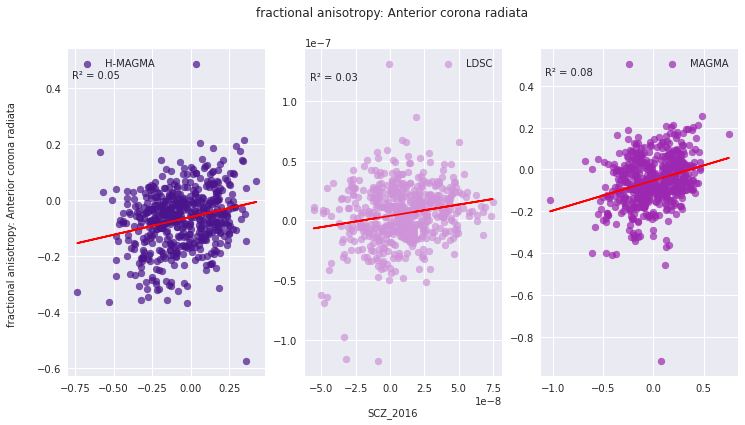

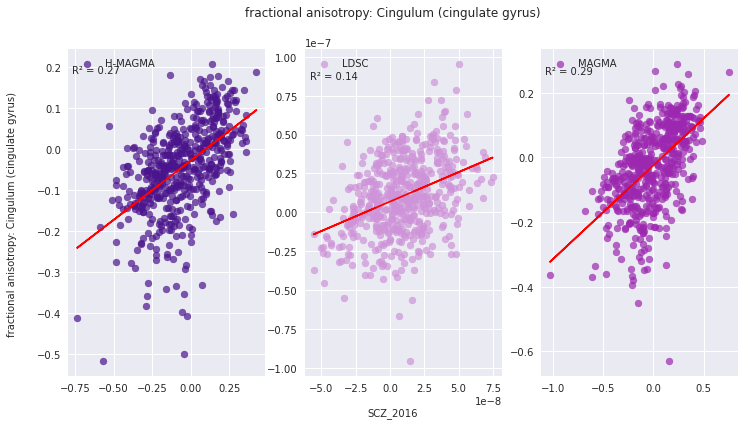

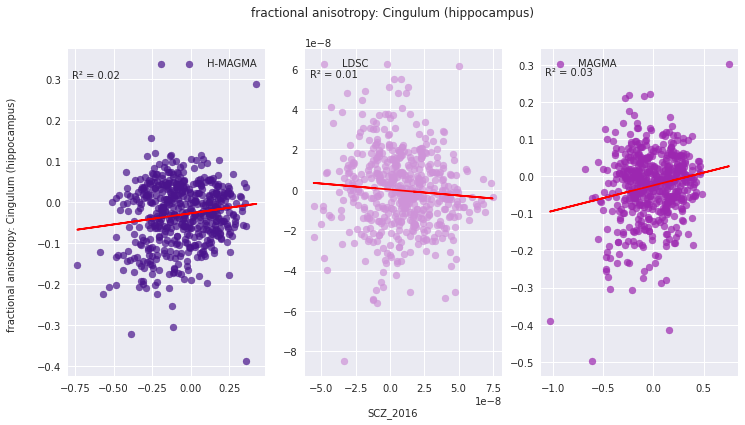

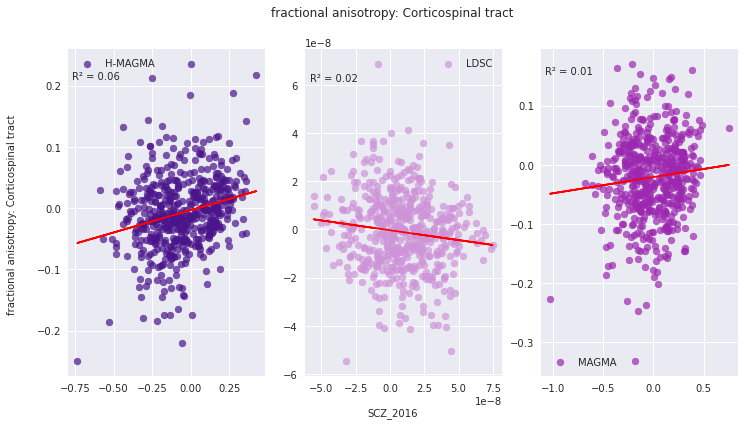

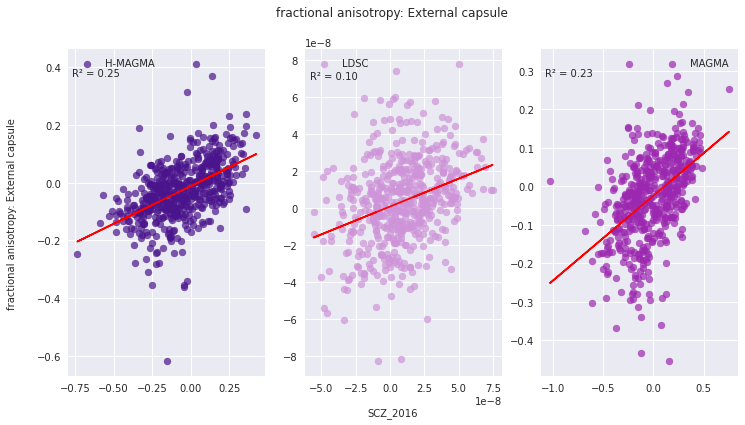

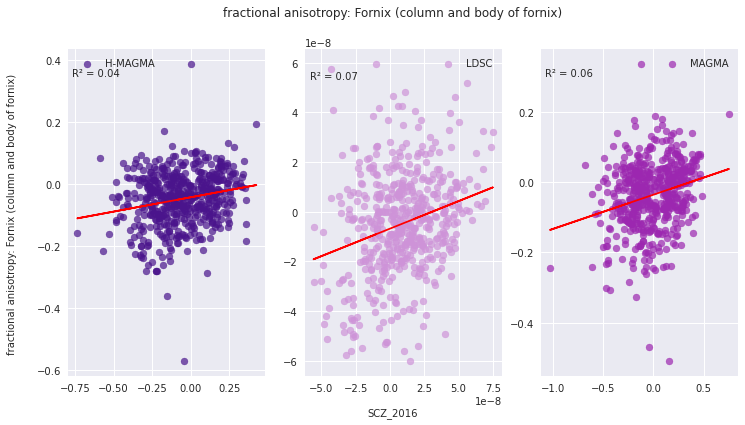

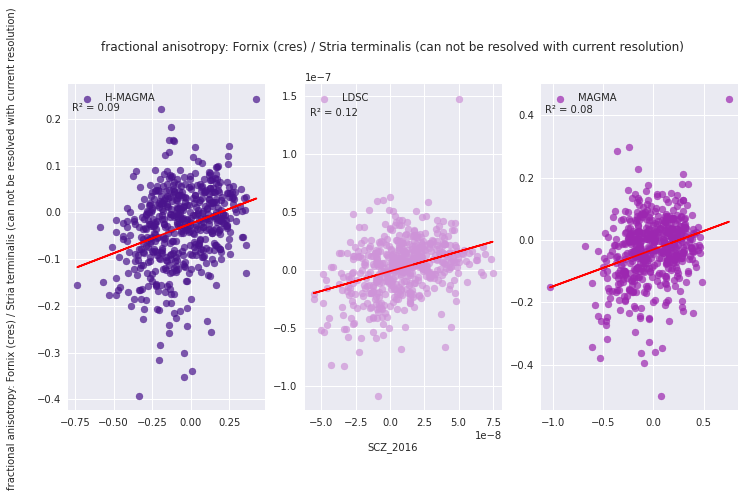

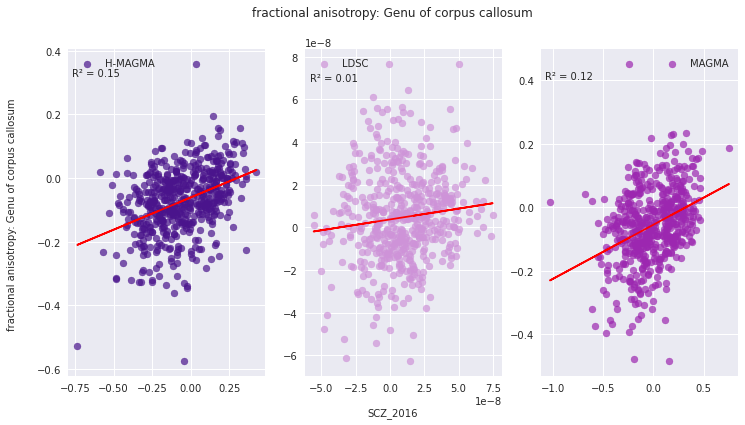

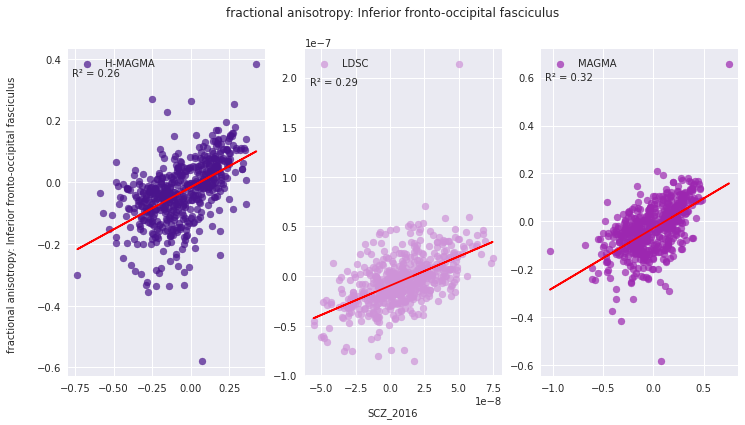

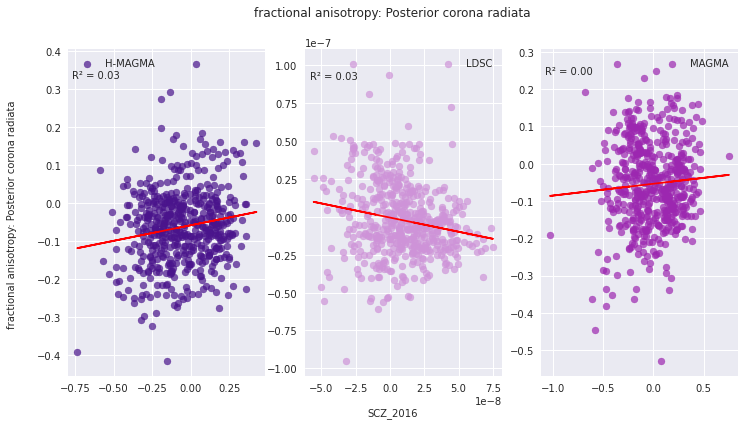

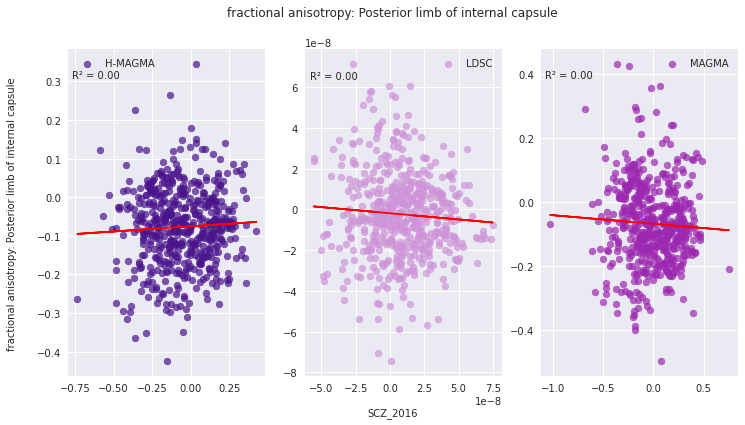

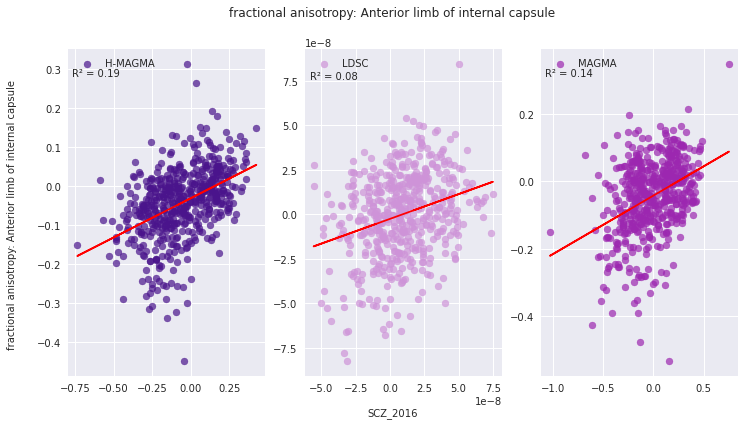

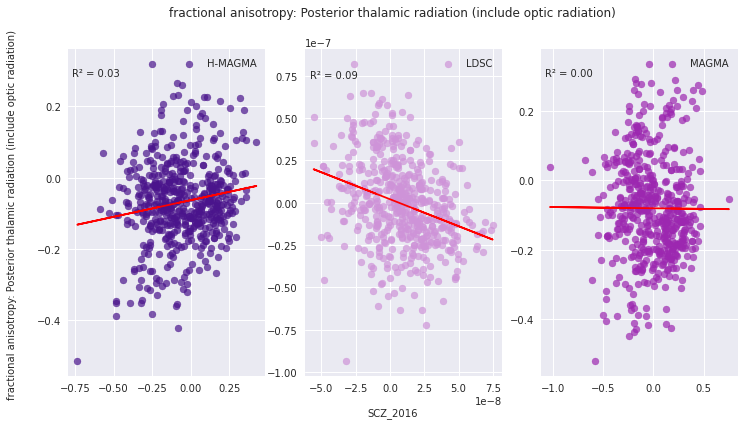

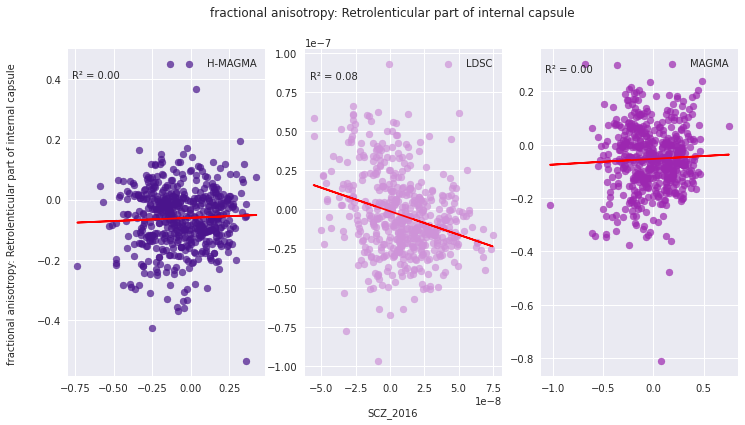

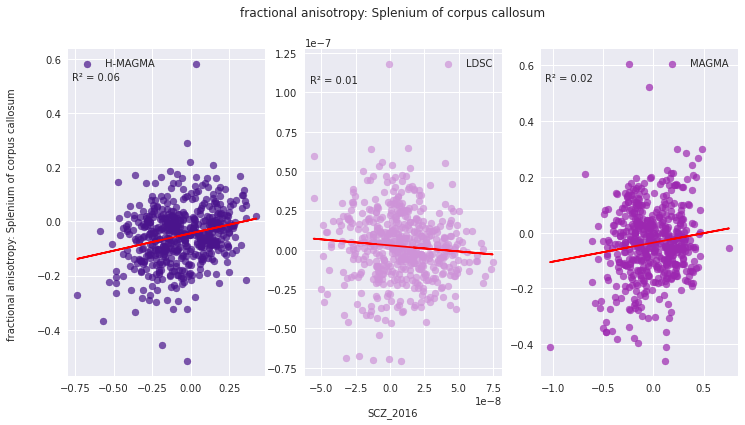

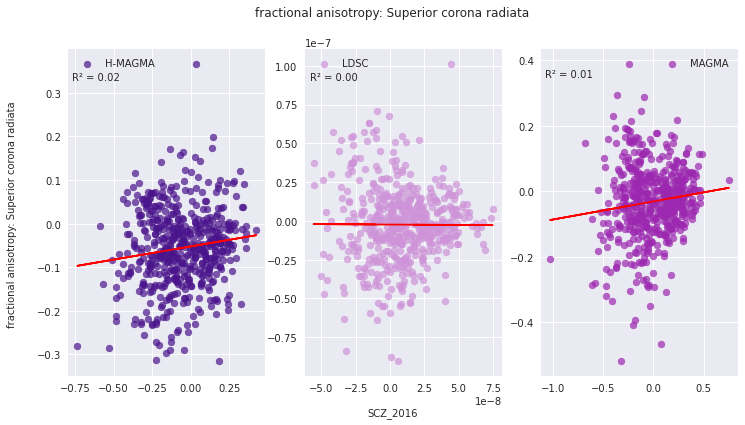

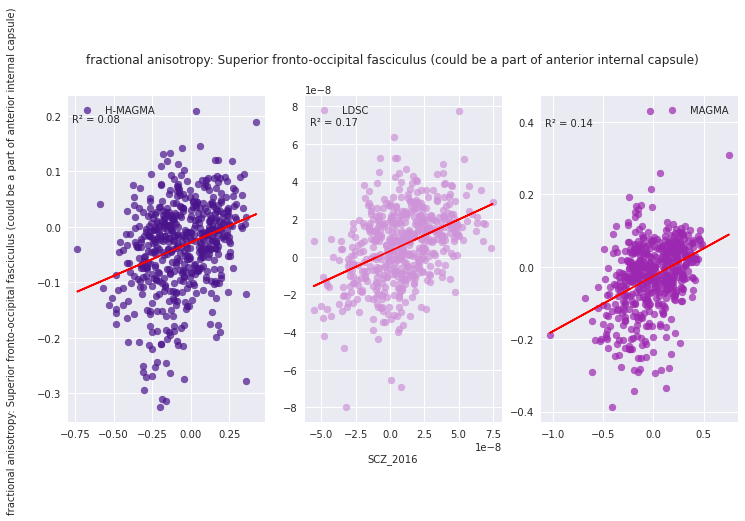

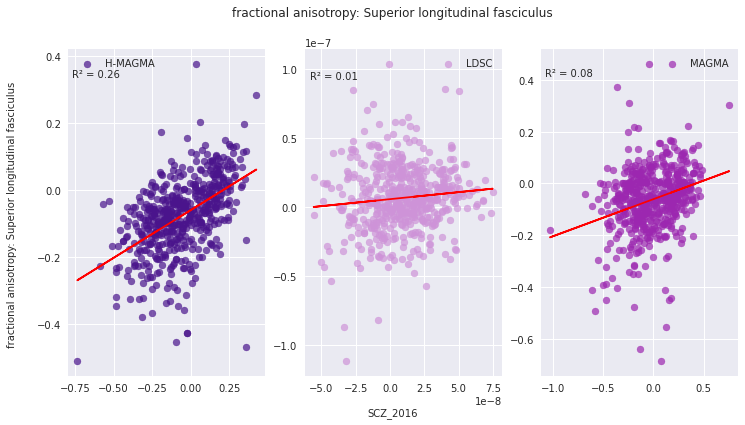

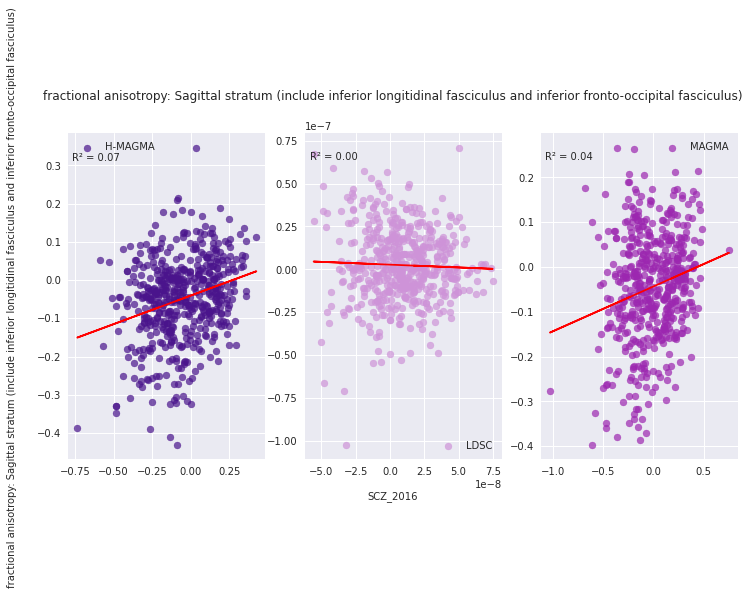

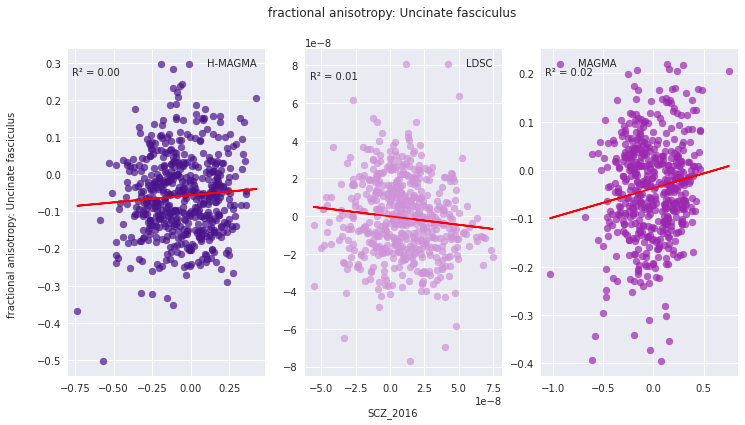

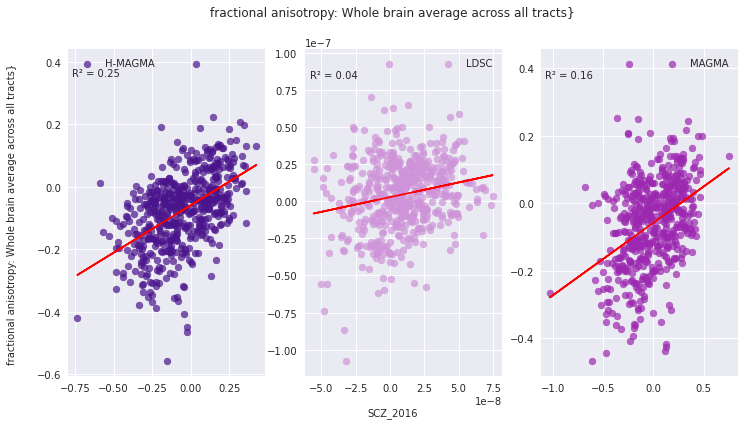

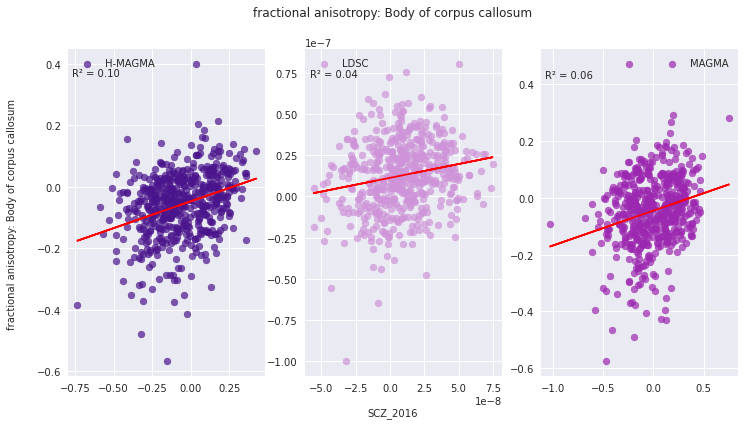

In [215]:
a = 'SCZ_2016'
# b = 'SCZ_2014'
# a = 'volume: caudate'
# b = 'volume: putamen'
# b = 'mean diusivities:Uncinate fasciculus'
# b = 'fractional anisotropy:Inferior fronto-occipital fasciculus'
b_list = df_new[df_new.gwas.str.contains('fractional')].gwas.unique()
color = ['#4A148C', '#CE93D8','#9C27B0']
for b in b_list:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
    for i,m in enumerate(methods):
        c = color[i]
        x,y = [df_new[(df_new.gwas==j)&(df_new.method==m)]['beta'] for j in [a,b]]
        ax[i].scatter(x,y,color=c,label=m, alpha=.7)
    #     lims = [np.min([ax[i].get_xlim(), ax[i].get_ylim()]),  
    #             np.max([ax[i].get_xlim(), ax[i].get_ylim()])]
    #     ax[i].plot(lims, lims, 'k-', alpha=0.75, zorder=0)

            # linear regression fit
        try:
            model = np.polyfit(x,y,1)
            predict = np.poly1d(model)
            ax[i].text(min(x)*1.05,max(y)*.9,f'R² = {r2_score(y, predict(x)):.2f}')
        except:
            pass
        ax[i].plot(x, predict(x), 'r')
        ax[i].legend()
    fig.text(0.06, 0.5, b, ha='center', va='center', rotation='vertical')
    fig.text(0.5, 0.04, a, ha='center', va='center')
    # plt.suptitle('Mousebrain beta')
    plt.suptitle(b)
    # plt.savefig(f"{out_dir}{a}/beta_{a}_vs_{b}.png", dpi=200, bbox_inches='tight')
    plt.show()


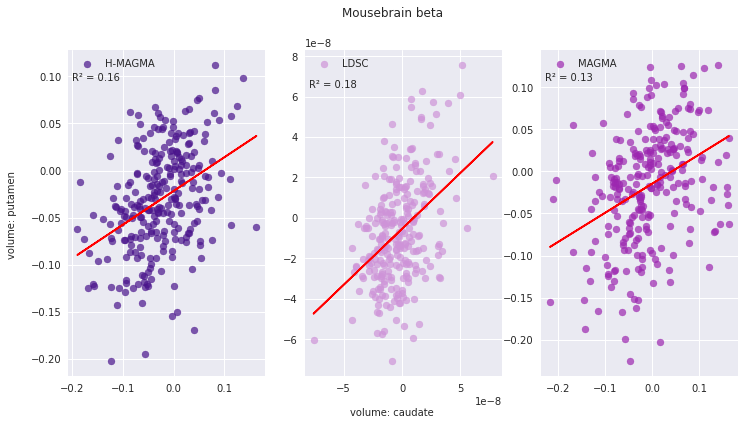

In [195]:
# a = 'SCZ_2016'
# b = 'SCZ_2014'
a = 'volume: caudate'
b = 'volume: putamen'
# b = 'mean diusivities:Uncinate fasciculus'
# b = 'fractional anisotropy:Inferior fronto-occipital fasciculus'
color = ['#4A148C', '#CE93D8','#9C27B0']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
for i,m in enumerate(methods):
    c = color[i]
    x,y = [df_all_mb[(df_all_mb.gwas==j)&(df_all_mb.method==m)]['beta'] for j in [a,b]]
    ax[i].scatter(x,y,color=c,label=m, alpha=.7)
#     lims = [np.min([ax[i].get_xlim(), ax[i].get_ylim()]),  
#             np.max([ax[i].get_xlim(), ax[i].get_ylim()])]
#     ax[i].plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        # linear regression fit
    model = np.polyfit(x,y,1)
    predict = np.poly1d(model)
    ax[i].text(min(x)*1.05,max(y)*.85,f'R² = {r2_score(y, predict(x)):.2f}')
    ax[i].plot(x, predict(x), 'r')
    ax[i].legend()
fig.text(0.06, 0.5, b, ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, a, ha='center', va='center')
plt.suptitle('Mousebrain beta')
# plt.savefig(f"{out_dir}{a}/beta_{a}_vs_{b}.png", dpi=200, bbox_inches='tight')
plt.show()


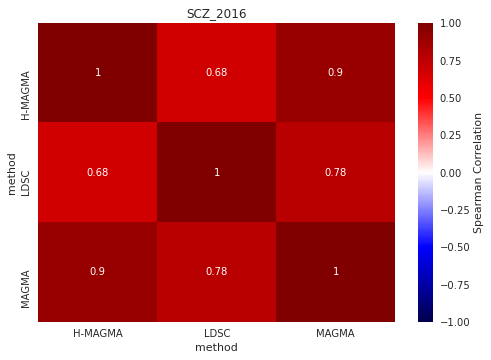

In [113]:
df_SCZ2016 = df_SCZ[df_SCZ.gwas=='SCZ_2016']
df_SCZ2016
df_b_SCZ = df_SCZ2016.pivot_table(index='annotation', columns='method', values='beta')
df_corr_SCZ = df_b_SCZ.corr('spearman')
plt.figure()
g = sns.heatmap(df_corr_SCZ, yticklabels=df_corr_SCZ.columns, xticklabels=df_corr_SCZ.columns,
            cmap="seismic",center=0, cbar_kws={'label': 'Spearman Correlation'},
            vmin=-1, vmax=1,annot=True,
               )
plt.title(name)
plt.savefig(f"{out_dir}/{name}/{name}_vs_methods_correlation.png", dpi=200, bbox_inches='tight')
plt.show()


In [ ]:
df_all_mb = df_new[df_new.specificity_id=='mousebrain']
df_corr_dict_SCZ = {}
for m in methods:
    df_all_mb_m = df_all_mb[df_all_mb.method==m]
#     df_cort_vol_m = df_cort_vol_m.assign(meta=df_cort_vol_m['region']+':'+df_cort_vol_m['sub_region'])
#     df_c = df_cort_vol_m.pivot(index='annotation', columns='meta', values='beta')
    df_s = df_all_mb_m.pivot(index='annotation', columns='gwas', values='beta')
#     df_concat = pd.concat([df_c, df_s], axis=1, sort=False)

    df_corr = df_s.corr('spearman')[['SCZ_2016']]
    df_corr_dict_SCZ[m] = df_corr

In [17]:
df_all_mb.gwas.unique()

array(['InstantCoffee_2019', 'HV_2016',
       'BIG-S2_ROIvolume_left_hippocampus2019',
       'BIG-S2_ROIvolume_right_hippocampus2019', 'SCZ_2014',
       'BMI_GIANT2018', 'AD_JANSEN2019', 'SCZ_2016', 'ASD_2019',
       'cortical thickness (adjusted for global thickness):Temporal.bankssts',
       'cortical thickness (adjusted for global thickness):Cingulate.caudalanteriorcingulate',
       'cortical thickness (adjusted for global thickness):Frontal.caudalmiddlefrontal',
       'cortical thickness (adjusted for global thickness):Cortex.cortex',
       'cortical thickness (adjusted for global thickness):Occipital.cuneus',
       'cortical thickness (adjusted for global thickness):Temporal.entorhinal',
       'cortical thickness (adjusted for global thickness):Frontal.frontalpole',
       'cortical thickness (adjusted for global thickness):Temporal.fusiform',
       'cortical thickness (adjusted for global thickness):Parietal.inferiorparietal',
       'cortical thickness (adjusted for g

In [ ]:
df_all_mb = df_new[df_new.specificity_id=='mousebrain']
df_corr_dict = {}
for m in methods:
    df_all_mb_m = df_all_mb[df_all_mb.method==m]
#     df_cort_vol_m = df_cort_vol_m.assign(meta=df_cort_vol_m['region']+':'+df_cort_vol_m['sub_region'])
#     df_c = df_cort_vol_m.pivot(index='annotation', columns='meta', values='beta')
    df_s = df_all_mb_m.pivot(index='annotation', columns='gwas', values='beta')
#     df_concat = pd.concat([df_c, df_s], axis=1, sort=False)

    df_corr = df_s.corr('spearman')
    df_corr_dict[m] = df_corr
    for i,(a,b) in enumerate([[0,9],[9,44],[44,66],[66,88],[88,129]]):
        plt.figure(figsize=(15,25))
        g = sns.heatmap(df_corr[a:b].T, yticklabels=df_corr.columns, xticklabels=df_corr[a:b].T.columns,
                    cmap="seismic",center=0, cbar_kws={'label': 'Spearman Correlation'},
                    vmin=-1, vmax=1,annot=False)
        plt.tight_layout()
        plt.title(m)
#         plt.savefig(f"{out_dir}/all_{m}_{i}_correlation.png", dpi=200)
        plt.show()
#     break
# df_s

In [ ]:
df_corr_FAMD

In [ ]:
#FA vs MD corr
for m in methods:
    df_corr = df_corr_dict[m]
    df_corr_FAMD = df_corr[(df_corr.columns.str.startswith('fractional'))|(df_corr.columns.str.startswith('mean'))]
    df_corr_FAMD = df_corr_FAMD.T[(df_corr.columns.str.startswith('fractional'))|(df_corr.columns.str.startswith('mean'))]
    fig, ax = plt.subplots(figsize=(15,15))
    g = sns.heatmap(df_corr_FAMD, yticklabels=df_corr_FAMD.columns, xticklabels=df_corr_FAMD.columns,
                cmap="seismic",center=0, cbar_kws={'label': 'Spearman Correlation'},
                vmin=-1, vmax=1,annot=False)
    plt.tight_layout()
    plt.title(m)
    for (ticky,tickx) in zip(ax.get_yticklabels(),ax.get_xticklabels()):
        if ticky.get_text().startswith('frac'):
            ticky.set_color('grey')
        if tickx.get_text().startswith('frac'):
            tickx.set_color('grey')
    plt.savefig(f"{out_dir}/FA_vs_MD_{m}_correlation.png", dpi=200)
    plt.show()

In [ ]:
df_corr_no1 = df_corr.replace(1,np.nan)
# plt.figure(figsize=(15,10))
# for g in ['AD_JANSEN2019', 'ASD_2019', 'BMI_GIANT2018','InstantCoffee_2019', 'SCZ_2016']:
# #     plt.hist(df_corr_no1[g])
# #     sns.distplot(df_corr_no1[g],bins=20, label=g, hist=False)
# #     sns.barplot(data=df_corr_no1[g],label=g)
#     df_corr_no1[g].bar()
# plt.legend()
# plt.show()

# df_corr_no1[['AD_JANSEN2019', 'BMI_GIANT2018','InstantCoffee_2019','SCZ_2014','SCZ_2016']]\
#     .plot(kind='barh', figsize=(15,20))

df_corr_no1[['AD_JANSEN2019', 'BMI_GIANT2018','InstantCoffee_2019','SCZ_2014','SCZ_2016']].sort_values(by='InstantCoffee_2019')\
    .plot(kind='line', figsize=(20,15))

In [ ]:
df_corr_no1[df_corr_no1.index.str.contains('volume:Parietal')]\
    .plot(kind='line', figsize=(20,15),legend=False)

In [ ]:
#????
df_andrew = df_corr_no1
df_andrew['gwas'] = df_andrew.index
df_andrew['gwas'] = df_andrew['gwas'].str.slice(stop=7)
pd.plotting.andrews_curves(df_andrew, 'gwas')

In [ ]:
df_SCZ16_mb
df_cort_vol

methods = df_SCZ16_mb.method.unique()
for m in methods:
    df_SCZ16_mb_m = df_SCZ16_mb[df_SCZ16_mb.method==m]
    df_cort_vol_m = df_cort_vol[df_cort_vol.method==m]
    df_cort_vol_m = df_cort_vol_m.assign(meta=df_cort_vol_m['region']+':'+df_cort_vol_m['sub_region'])
    df_c = df_cort_vol_m.pivot(index='annotation', columns='meta', values='beta')
    df_s = df_SCZ16_mb_m.pivot(index='annotation', columns='gwas', values='beta')
    df_concat = pd.concat([df_c, df_s], axis=1, sort=False)

    df_corr = df_concat.corr('spearman')
    plt.figure(figsize=(15,10))
    g = sns.heatmap(df_corr, xticklabels=df_corr.columns, yticklabels=df_corr.columns,
                cmap="seismic",center=0, cbar_kws={'label': 'Spearman Correlation'},
                vmin=-1, vmax=1,annot=False)
    plt.tight_layout()
    plt.title(m)
#     plt.savefig(f"{out_dir}/{name}/{name}_{m}_correlation.png", dpi=200)
    plt.show()


In [ ]:
df_corr

### Plot all prioritization.csv files

In [ ]:
dataframe = df_SCZ16

scrnaseq_unqiue = dataframe['specificity_id'].unique()
n_gwas = len(dataframe['gwas'].unique())
p_max = dataframe['-log10(p)'].max()
methods = dataframe['method'].unique()
color = sns.color_palette("muted",n_colors=len(methods))
for scrnaseq in scrnaseq_unqiue: # split by scrnaseq data to create smaller plots
    df = dataframe[dataframe['specificity_id'] == scrnaseq]
    n_celltypes = len(df['annotation'].unique())
    g = sns.relplot(x='annotation', y='-log10(p)', hue='method', data=df,
                style='gwas', hue_order=methods, palette=color,
#                 aspect=10, height=8,
               )
    legend = g._legend
    legend.set_bbox_to_anchor([1,.9])
    p_thres = -np.log10(0.05/n_celltypes) #what is the exact threshold?
    plt.axhline(p_thres, linestyle='--', c='k')
    plt.xticks(rotation=45, size=7,
               rotation_mode='anchor',
               horizontalalignment='center',
              verticalalignment='top')
    plt.yticks(range(0,int(p_max)+1,1),linespacing=4)
    ax = plt.gca()
    ax.tick_params(axis='x', which='both', pad=df['annotation'].str.len().max())
    plt.xlim(left=-1, right=n_celltypes+1)
    plt.xlabel(scrnaseq)

#     annot_associated = [[i%(len(df)/len(methods)),p,a] # probably not fully correct!!
#                         for i,(a,p) in enumerate(zip(df['annotation'],df['-log10(p)'])) 
#                         if p>=p_thres]
#     for x,y,annot in annot_associated:
#         plt.text(((x+1)/n_gwas)-1, y+.1, annot, rotation=45)
    plt.tight_layout()
#     plt.savefig(f'{out_dir}{name}_{scrnaseq}.png', dpi=200) 
#     plt.clf()
